# Prediction of bookings based on user behavior
Data Scientist – User Profiling, Hotel Search

- Author: Kai Chen
- Date: Apr, 2018

There are 3 types of data: Bookings, User actions, Example

## Data: Bookings
- Description: List of sessions, each with: session-related contextual data, and whether at least one booking was made
- Files:
	- case_study_bookings_train.csv: Training sessions for bookings
	- case_study_bookings_target.csv: Target sessions to predict bookings
- Rows: Each row represents a session with session context and the outcome of this session
- Columns:
	- ymd: Date of the session in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- referer_code: Encoded category of the referer to the website
	- is_app: If the session was made using the trivago app
	- agent_id: Encoded type of the browser
	- traffic_type: A categorization of the type of the traffic
	- has_booking: 1 if at least one booking was made during the session (excluded from the target set)
    
## Data: User Actions
- Description: Sequence of various type of user actions generated during the usage of the website.
- Files
	- case_study_actions_train.csv: Training set of user actions
	- case_study_actions_target.csv: User actions in the target sessions
- Rows: Each row represents one action from/to the user
- Columns:
	- ymd: Date of the action in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- action_id: Type of the action
	- reference: Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
	- step: The number identifying the action in the session
	
## Data: Example Solution
- Description: List of predictions for bookings in the target sessions
- File: case_study_bookings_target_prediction_example.csv
- Rows: Each row represent a target session for which a prediction should be given
- Columns:
	- session_id: Anonymized id of the session
	- has_booking: Random binary predictions for bookings

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
from datetime import datetime

import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# ---
# Define file paths
TRAIN_BOOKING_FILE_PATH = 'data/case_study_bookings_train.csv'    # training sessions for bookings
TARGET_BOOKING_FILE_PATH = 'data/case_study_bookings_target.csv'  # target sessions to predict bookings

TRAIN_ACTION_FILE_PATH = 'data/case_study_actions_train.csv'       # training set of user actions
TARGET_ACTION_FILE_PATH = 'data/case_study_actions_target.csv'     # user actions in the target sessions

## Step 1: read and explore the data

In [5]:
"""
train booking data
- ymd: Date of the session in format 'yyMMdd'
- user_id: Anonymized cookie id of the visitor
- session_id: Anonymized id of the session
- referer_code: Encoded category of the referer to the website
- is_app: If the session was made using the trivago app
- agent_id: Encoded type of the browser
- traffic_type: A categorization of the type of the traffic
- has_booking: 1 if at least one booking was made during the session (excluded from the target set)
"""

train_booking_df = pd.read_csv(TRAIN_BOOKING_FILE_PATH, sep='\t')
train_booking_df['ymd'] = pd.to_datetime(train_booking_df['ymd'].astype('str'))

print('train booking')
print(train_booking_df.columns)
print(train_booking_df.describe())
display(train_booking_df.head(5))

train booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'has_booking'],
      dtype='object')
            user_id    session_id   referer_code         is_app  \
count  3.076770e+05  3.076770e+05  307677.000000  307677.000000   
mean   4.622586e+18  4.609514e+18      22.857828       0.073571   
std    2.665868e+18  2.662771e+18      40.179017       0.261071   
min    3.883091e+14  1.097161e+14       0.000000       0.000000   
25%    2.312274e+18  2.303980e+18       0.000000       0.000000   
50%    4.635855e+18  4.612005e+18       1.000000       0.000000   
75%    6.932941e+18  6.912236e+18      15.000000       0.000000   
max    9.223267e+18  9.223359e+18      99.000000       1.000000   

            agent_id   traffic_type    has_booking  
count  307677.000000  307677.000000  307677.000000  
mean        7.424809       2.686174       0.063856  
std         3.713358       1.906000       0.244497  
min         0.000000       1.000

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking
0,2017-04-23,388309106223940,3052767322364990735,0,0,2,1,0
1,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0
2,2017-04-15,452426828488840,4191504489082712531,0,0,10,2,0
3,2017-04-06,819438352219100,4560227804862289210,1,0,1,1,0
4,2017-04-07,1113732603712480,4115013282086590434,0,0,9,2,0


In [6]:
"""
target booking data
- ymd: Date of the session in format 'yyMMdd'
- user_id: Anonymized cookie id of the visitor
- session_id: Anonymized id of the session
- referer_code: Encoded category of the referer to the website
- is_app: If the session was made using the trivago app
- agent_id: Encoded type of the browser
- traffic_type: A categorization of the type of the traffic
"""

target_booking_df = pd.read_csv(TARGET_BOOKING_FILE_PATH, sep='\t')
target_booking_df['ymd'] = pd.to_datetime(target_booking_df['ymd'].astype('str'))

print('target booking')
print(target_booking_df.columns)
display(target_booking_df.head(5))

target booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type'],
      dtype='object')


,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type
0,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6
1,2017-04-30,1607565913119260,9175174925268392332,0,0,14,1
2,2017-04-30,2669945826129900,5361965966177226983,0,0,6,6
3,2017-04-30,6247954936827660,7996347049132178025,0,0,13,2
4,2017-04-30,6447705595982360,6061498713259551906,99,0,1,6


In [7]:
# get number of users and sessions in the train booking data

train_user_id_list = train_booking_df['user_id'].unique()
train_session_id_list = train_booking_df['session_id'].unique()

print('number of users (train booking data): {}'.format(len(train_user_id_list)))
print('number of sessions (tarin booking data): {}'.format(len(train_session_id_list)))
print('dataframe size (train booking data)')
print(train_booking_df.shape)

number of users (train booking data): 181860
number of sessions (tarin booking data): 307677
dataframe size (train booking data)
(307677, 8)


In [9]:
# get number of users and sessions in the target booking data

target_user_id_list = target_booking_df['user_id'].unique()
target_session_id_list = target_booking_df['session_id'].unique()

print('number of users (target booking data): {}'.format(len(target_user_id_list)))
print('number of sessions (target booking data): {}'.format(len(target_session_id_list)))
print('dataframe size (target booking data)')
print(target_booking_df.shape)

number of users (target booking data): 23402
number of sessions (target booking data): 30128
dataframe size (target booking data)
(30128, 7)


In [10]:
"""
train action data
- ymd: Date of the action in format 'yyMMdd'
- user_id: Anonymized cookie id of the visitor
- session_id: Anonymized id of the session
- action_id: Type of the action
- reference: Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
- step: The number identifying the action in the session
"""
train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))

print('train action')
print(train_action_df.columns)
print(train_action_df.describe())
display(train_action_df.head(5))

train action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
            user_id    session_id     action_id     reference          step
count  5.862863e+06  5.862863e+06  5.862863e+06  5.862863e+06  5.862863e+06
mean   4.612543e+18  4.607893e+18  2.813712e+03  4.898678e+05  5.464623e+01
std    2.657161e+18  2.656793e+18  1.635718e+03  2.865848e+06  1.319077e+02
min    3.883091e+14  1.097161e+14  2.900000e+01 -1.000000e+00  1.000000e+00
25%    2.307275e+18  2.310688e+18  2.119000e+03  1.000000e+00  6.000000e+00
50%    4.624574e+18  4.606641e+18  2.146000e+03  3.164400e+04  1.800000e+01
75%    6.897454e+18  6.892497e+18  2.501000e+03  1.297190e+05  4.800000e+01
max    9.223267e+18  9.223359e+18  8.091000e+03  6.814322e+08  3.133000e+03


,ymd,user_id,session_id,action_id,reference,step
0,2017-04-23,388309106223940,3052767322364990735,8001,1323836,1
1,2017-04-10,452426828488840,1022778951418899936,2116,929835,1
2,2017-04-10,452426828488840,1022778951418899936,6999,0,2
3,2017-04-10,452426828488840,1022778951418899936,2116,929835,3
4,2017-04-10,452426828488840,1022778951418899936,2503,1,4


In [11]:
# get number of users and sessions in the action list
train_user_id_action_list = train_action_df['user_id'].unique()
train_session_id_action_list = train_action_df['session_id'].unique()

print('number of users (train action data): {}'.format(len(train_user_id_action_list)))
print('number of sessions (train action data): {}'.format(len(train_session_id_action_list)))
print('dataframe size (train booking data)')
print(train_action_df.shape)

number of users (train action data): 181730
number of sessions (train action data): 306106
dataframe size (train booking data)
(5862863, 6)


In [17]:
print(len(set(train_user_id_list) - set(train_user_id_action_list)))

print(len(set(train_user_id_action_list) - set(train_user_id_list)))

# all the users who have an action can be found in the booking data
# 130 users in the traing data do not have actions

130
0


In [14]:
# get user who does have action information
train_user_id_no_action_list = []
for user_id in train_user_id_list:
    if not user_id in train_user_id_action_list:
        train_user_id_no_action_list.append(user_id)
    
print(len(train_user_id_no_action_list))

130


In [16]:
nb_bookings_action = []
nb_bookings_no_action = []

for user_id in train_user_id_list:
    nb_bookings = np.sum(train_booking_df[train_booking_df['user_id'] == user_id]['has_booking'].values)
    nb_bookings_action.append(nb_bookings)

for user_id in train_user_id_no_action_list:
    nb_bookings = np.sum(train_booking_df[train_booking_df['user_id'] == user_id]['has_booking'].values)
    nb_bookings_no_action.append(nb_bookings)
    
    
print('number of users (with action): {}'.format(len(train_user_id_list))) 
print('number of users (without action): {}'.format(len(train_user_id_no_action_list))) 
print('number of bookings (with action): {}'.format(np.sum(nb_bookings_action)))
print('number of bookings (without action): {}'.format(np.sum(nb_bookings_no_action)))
print('mean number of bookings (with action): {}'.format(np.mean(nb_bookings_action)))
print('mean number of bookings (without action): {}'.format(np.mean(nb_bookings_no_action)))
print('standard deviation number of bookings (with action): {}'.format(np.std(nb_bookings_action)))
print('standard deviation number of bookings (without action): {}'.format(np.std(nb_bookings_no_action)))
        
# This shows that users without action are more likely to book a hotel.

number of users (with action): 181860
number of users (without action): 130
number of bookings (with action): 19647
number of bookings (without action): 103
mean number of bookings (with action): 0.1080336522599802
mean number of bookings (without action): 0.7923076923076923
standard deviation number of bookings (with action): 0.3341389925584934
standard deviation number of bookings (without action): 0.829236477788257


In [47]:
action_id_list = train_action_df['action_id'].unique()
print('action id')
print(action_id_list)
print(len(action_id_list))
min_action_id = np.min(action_id_list)
print('min action id: {}'.format(min_action_id))
max_action_id = np.max(action_id_list)
print('max action id: {}'.format(max_action_id))

reference_list = train_action_df['reference'].unique()
print('reference id')
print(reference_list)
print(len(reference_list))
min_reference = np.min(reference_list)
max_reference = np.max(reference_list)
print('min reference {}'.format(min_reference))
print('max reference {}'.format(max_reference))

corr_score = train_user_df['action_id'].corr(train_user_df['reference'])
print(corr_score)

action id
[8001 2116 6999 2503 2113 2100 2362 2306 2358 2350 2146 2331 2145 2122
 2502 2166 2260 2296 8010 2119 2115 2351 2175 2142 2314 2111 2357 2123
 2367 2262 2501 2133 2136 2135 2216 2121 2257 2188 2155 2114 2700 2788
 2784 2884 2710 2791 2726 2792 2702 2226 2252 2156 2504 2863 2773 2721
 2776 2840 2765 2720 2227 2143 2356 2307 2124 2391 2440 2301 2789 2881
 2713 2701 2777 2845 2779 2750 2728 2873 2719 2126 2206 2291 2894 2793
 2897 2778 2848 2860 2851 2853 2844 2704 2759 2761 2706 2892 2820 2850
 2781 2751 2752 2888 2893 2128 2125 2725 2352 2215 2371 2448 2255 2364
 2279 2359 2160 2790 2302 2200 2842 2812 2309 2365 8002 2186 2132 2130
 2714 2846 2733 2887 2134 2205 2131 2729 2735 2794 2711 2811 2814 2731
 2753 2703 2885 2727 2730 8020 2170 2370 2449 2755 2775 2895 2764 2797
 2712 2843 2443 2442 2446 2445 2310 2353 2168 2874 2707 2878 2734 2841
 2385 2732 2292 2876 2875 2869 2148 2891 2857 2856 2705 2380 2137 8006
 2181 2283 2153 2865 2855 2882 2441 2785 2852 2854 2858 2859 2191  

In [18]:
"""
target action data
- ymd: Date of the action in format 'yyMMdd'
- user_id: Anonymized cookie id of the visitor
- session_id: Anonymized id of the session
- action_id: Type of the action
- reference: Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
- step: The number identifying the action in the session
"""

target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))

print('target action')
print(target_action_df.columns)
print(target_action_df.describe())
print(target_action_df.head(5))

target action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
            user_id    session_id      action_id     reference           step
count  5.751520e+05  5.751520e+05  575152.000000  5.751520e+05  575152.000000
mean   4.620294e+18  4.648837e+18    2796.277468  4.831560e+05      60.934040
std    2.669707e+18  2.671616e+18    1600.930226  2.488881e+06     150.311639
min    1.607566e+15  2.886847e+14      29.000000 -1.000000e+00       1.000000
25%    2.263261e+18  2.313074e+18    2119.000000  1.000000e+00       6.000000
50%    4.624574e+18  4.646138e+18    2146.000000  3.146400e+04      18.000000
75%    6.952373e+18  7.010441e+18    2503.000000  1.316782e+05      50.000000
max    9.223058e+18  9.223352e+18    8020.000000  7.055946e+08    2299.000000
         ymd           user_id           session_id  action_id  reference  \
0 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
1 2017-04-30  1607565913119260  41759398

In [19]:
target_user_id_action_list = target_action_df['user_id'].unique()
target_session_id_action_list = target_action_df['session_id'].unique()

print('number of users (target action data): {}'.format(len(target_user_id_action_list)))
print('number of sessions (target action data): {}'.format(len(target_session_id_action_list)))
print('dataframe size (target booking data)')
print(target_action_df.shape)

number of users (target action data): 23314
number of sessions (target action data): 29957
dataframe size (target booking data)
(575152, 6)


In [63]:
# replace the NAN values by a specific value

NA_ACTION_ID = -10
NA_REFERENCE_ID = -10
NA_STEP = 0

In [64]:
train_user_df =  pd.merge(train_booking_df, train_action_df, on=['ymd', 'user_id', 'session_id'], how='left')

print('number of rows where action id is NaN: {}'.format(train_user_df['action_id'].isnull().sum()))
print('number of rows where reference is NaN: {}'.format(train_user_df['reference'].isnull().sum()))
print('number of rows where step is NaN: {}'.format(train_user_df['step'].isnull().sum()))
#print(train_user_df[train_user_df['action_id'].isnull() | train_user_df['reference'].isnull()])

train_user_df['action_id'].fillna(NA_ACTION_ID, inplace=True)
train_user_df['reference'].fillna(NA_REFERENCE_ID, inplace=True)
train_user_df['step'].fillna(NA_STEP, inplace=True)

print('number of rows where action id is NaN: {}'.format(train_user_df['action_id'].isnull().sum()))
print('number of rows where reference is NaN: {}'.format(train_user_df['reference'].isnull().sum()))
print('number of rows where step is NaN: {}'.format(train_user_df['step'].isnull().sum()))
#print(train_user_df[train_user_df['action_id'].isnull() | train_user_df['reference'].isnull()])

train_user_df['action_id'] = train_user_df['action_id'].astype('int')
train_user_df['reference'] = train_user_df['reference'].astype('int')
train_user_df['step'] = train_user_df['step'].astype('int')

print(train_user_df.columns)
print(train_user_df.describe())
print('train user df shape')
print(train_user_df.shape)
display(train_user_df.head(5))
print('number of users {}'.format(len(train_user_df['user_id'].unique())))

number of rows where action id is NaN: 1571
number of rows where reference is NaN: 1571
number of rows where step is NaN: 1571
number of rows where action id is NaN: 0
number of rows where reference is NaN: 0
number of rows where step is NaN: 0
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'has_booking', 'action_id', 'reference', 'step'],
      dtype='object')
            user_id    session_id  referer_code        is_app      agent_id  \
count  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06  5.864434e+06   
mean   4.612515e+18  4.607873e+18  1.050245e+01  1.247070e-01  7.267086e+00   
std    2.657178e+18  2.656793e+18  2.855244e+01  3.303864e-01  3.802190e+00   
min    3.883091e+14  1.097161e+14  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.307265e+18  2.310716e+18  0.000000e+00  0.000000e+00  6.000000e+00   
50%    4.624574e+18  4.606553e+18  1.000000e+00  0.000000e+00  9.000000e+00   
75%    6.897454e+18  6.892477e

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking,action_id,reference,step
0,2017-04-23,388309106223940,3052767322364990735,0,0,2,1,0,8001,1323836,1
1,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,2116,929835,1
2,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,6999,0,2
3,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,2116,929835,3
4,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,2503,1,4


number of users 181860


In [65]:
print('ymd (train)')
print(train_user_df['ymd'].unique())

ymd (train)
['2017-04-23T00:00:00.000000000' '2017-04-10T00:00:00.000000000'
 '2017-04-15T00:00:00.000000000' '2017-04-06T00:00:00.000000000'
 '2017-04-07T00:00:00.000000000' '2017-04-19T00:00:00.000000000'
 '2017-04-16T00:00:00.000000000' '2017-04-17T00:00:00.000000000'
 '2017-04-04T00:00:00.000000000' '2017-04-13T00:00:00.000000000'
 '2017-04-08T00:00:00.000000000' '2017-04-25T00:00:00.000000000'
 '2017-04-09T00:00:00.000000000' '2017-04-12T00:00:00.000000000'
 '2017-04-03T00:00:00.000000000' '2017-04-24T00:00:00.000000000'
 '2017-04-27T00:00:00.000000000' '2017-04-26T00:00:00.000000000'
 '2017-04-02T00:00:00.000000000' '2017-04-14T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' '2017-04-22T00:00:00.000000000'
 '2017-04-20T00:00:00.000000000' '2017-04-11T00:00:00.000000000'
 '2017-04-18T00:00:00.000000000' '2017-04-21T00:00:00.000000000'
 '2017-04-01T00:00:00.000000000']


In [67]:
target_user_df =  pd.merge(target_booking_df, target_action_df, on=['ymd', 'user_id', 'session_id'], how='left')

print('number of rows where action id (target) is NaN: {}'.format(target_user_df['action_id'].isnull().sum()))
print('number of rows where reference (target) is NaN: {}'.format(target_user_df['reference'].isnull().sum()))
print('number of rows where step is (target) NaN: {}'.format(target_user_df['step'].isnull().sum()))
#print(target_user_df[train_user_df['action_id'].isnull() | target_user_df['reference'].isnull()])

target_user_df['action_id'].fillna(NA_ACTION_ID, inplace=True)
target_user_df['reference'].fillna(NA_REFERENCE_ID, inplace=True)
target_user_df['step'].fillna(NA_STEP, inplace=True)

print('number of rows where action id (target) is NaN: {}'.format(target_user_df['action_id'].isnull().sum()))
print('number of rows where reference (target) is NaN: {}'.format(target_user_df['reference'].isnull().sum()))
print('number of rows where step is (target) NaN: {}'.format(target_user_df['step'].isnull().sum()))
#print(train_user_df[train_user_df['action_id'].isnull() | train_user_df['reference'].isnull()])

target_user_df['action_id'] = target_user_df['action_id'].astype('int')
target_user_df['reference'] = target_user_df['reference'].astype('int')
target_user_df['step'] = target_user_df['step'].astype('int')

print(target_user_df.columns)
print(target_user_df.describe())
print('target user df shape')
print(target_user_df.shape)
display(target_user_df.head(5))
print('number of users (target) {}'.format(len(target_user_df['user_id'].unique())))


number of rows where action id (target) is NaN: 171
number of rows where reference (target) is NaN: 171
number of rows where step is (target) NaN: 171
number of rows where action id (target) is NaN: 0
number of rows where reference (target) is NaN: 0
number of rows where step is (target) NaN: 0
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'action_id', 'reference', 'step'],
      dtype='object')
            user_id    session_id   referer_code         is_app  \
count  5.753230e+05  5.753230e+05  575323.000000  575323.000000   
mean   4.620225e+18  4.648770e+18      11.004495       0.135762   
std    2.669715e+18  2.671621e+18      29.310329       0.342536   
min    1.607566e+15  2.886847e+14       0.000000       0.000000   
25%    2.263261e+18  2.313074e+18       0.000000       0.000000   
50%    4.624574e+18  4.646138e+18       1.000000       0.000000   
75%    6.952373e+18  7.010441e+18       1.000000       0.000000   
max    9.22

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,action_id,reference,step
0,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6,2113,60196,1
1,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6,6999,0,2
2,2017-04-30,1607565913119260,4175939893794521966,0,0,14,6,2113,60196,3
3,2017-04-30,1607565913119260,9175174925268392332,0,0,14,1,2100,0,1
4,2017-04-30,1607565913119260,9175174925268392332,0,0,14,1,6999,0,2


number of users (target) 23402


In [68]:
print('ymd (target)')
print(target_user_df['ymd'].unique())

ymd (target)
['2017-04-30T00:00:00.000000000' '2017-04-28T00:00:00.000000000'
 '2017-04-29T00:00:00.000000000']


In [76]:
train_user_id_list = train_user_df['user_id'].unique()

print('number of users (train) {}'.format(len(train_user_id_list)))

target_user_id_list = target_user_df['user_id'].unique()

print('number of users (target) {}'.format(len(target_user_id_list)))


print('\nnumber of different users between train user id and target user id')
print(len(set(train_user_id_list) - set(target_user_id_list)))
print(len(set(target_user_id_list) - set(train_user_id_list)))

intersect_user_id_list = []
for user_id in target_user_id_list:
    if user_id in train_user_id_list:
        intersect_user_id_list.append(user_id)
    
print('number of users in target data can be found in train data {}'.format(len(intersect_user_id_list)))

# Although I find that 8062/23402 users in the target set can be found in the train set, 
# I am doubt taking 'user_id' as features may overfit the model.

number of users (train) 181860
number of users (target) 23402

number of different users between train user id and target user id
173798
15340
number of users in target data can be found in train data 8062


In [77]:
print('correlation')

corr_score = train_user_df['user_id'].corr(train_user_df['has_booking'])
print('corr score of user_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['referer_code'].corr(train_user_df['has_booking'])
print('corr score of referer_code and has_booking {}'.format(corr_score))

corr_score = train_user_df['is_app'].corr(train_user_df['has_booking'])
print('corr score of is_app and has_booking {}'.format(corr_score))

corr_score = train_user_df['agent_id'].corr(train_user_df['has_booking'])
print('corr score of agent_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['traffic_type'].corr(train_user_df['has_booking'])
print('corr score of traffic_type and has_booking {}'.format(corr_score))

corr_score = train_user_df['action_id'].corr(train_user_df['has_booking'])
print('corr score of action_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['reference'].corr(train_user_df['has_booking'])
print('corr score of reference and has_booking {}'.format(corr_score))

corr_score = train_user_df['step'].corr(train_user_df['has_booking'])
print('corr score of step and has_booking {}'.format(corr_score))

correlation
corr score of user_id and has_booking 0.010530781795338581
corr score of referer_code and has_booking -0.0500361053699574
corr score of is_app and has_booking -0.05041751153650551
corr score of agent_id and has_booking -0.10280097418169962
corr score of traffic_type and has_booking -0.08016006610302687
corr score of action_id and has_booking 0.008116543113345991
corr score of reference and has_booking 0.00579133887101014
corr score of step and has_booking 0.08525424479513023


In [32]:
def get_nb_bookings_dict(df, column_name, has_booking_name='has_booking'):
    # key: column value  value: number of bookings
    dict_nb_bookings = dict()
    col_list = df[column_name].unique()
    # print(column_name)
    # print(col_list)
    for value in col_list:
        values = df[train_user_df[column_name] == value][has_booking_name].values
        dict_nb_bookings[value] = sum(values)

    return dict_nb_bookings, col_list

In [ ]:
def save_dict_to_csv(data_dict, csv_path):
    w = csv.writer(open(csv_path, "w"))
    for key, val in data_dict.items():
        w.writerow([key, val])

def read_dict_from_csv(csv_path):
    reader = csv.reader(open(csv_path))
    result = {}
    for row in reader:
        key = row[0]
        result[key] = row[1:]
    return result

In [41]:
# Although I find that 8062/23402 users in the target set can be found in the train set, 
# I am doubt taking 'user_id' as features may overfit the model.

feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']

dict_feature_nb_bookings = dict()
dict_feature_list = dict()

for feature_column in feature_columns:
    dict_feature_column, feature_column_list = get_nb_bookings_dict(train_user_df, feature_column)
    
    dict_feature_nb_bookings[feature_column] = dict_feature_column
    dict_feature_list[feature_column] = feature_column_list
    
    print('\n --------------------')
    print(feature_column)
    print(feature_column_list)
    print('{}, {}'.format(feature_column, 'nb bookings'))
    for key, value in dict_feature_column.items():
        print('{}, {}'.format(key, value))
    print('\n --------------------\n')
    
    # save the dictionary
    csv_path = '{}-nb_bookings.csv'.format(feature_column)
    save_dict_to_csv(data_dict, csv_path)
    print('save dictionary to {}'.format(csv_path))
    


 --------------------
referer_code
[ 0  1 99 15 11 10 24 21 23 17 19]
referer_code, nb bookings
0, 308655
1, 366608
99, 43789
15, 1297
11, 29141
10, 10611
24, 0
21, 1785
23, 402
17, 21
19, 0

 --------------------


 --------------------
is_app
[0 1]
is_app, nb bookings
0, 700019
1, 62290

 --------------------


 --------------------
agent_id
[ 2 10  1  9 14  7  8  6 13  0 12 11  3  4  5]
agent_id, nb bookings
2, 33809
10, 78428
1, 224860
9, 128684
14, 41493
7, 69655
8, 100821
6, 57062
13, 22576
0, 2848
12, 711
11, 1354
3, 8
4, 0
5, 0

 --------------------


 --------------------
traffic_type
[ 1  2  6  4  3  7 10]
traffic_type, nb bookings
1, 507089
2, 172942
6, 35121
4, 4504
3, 42193
7, 56
10, 404

 --------------------


 --------------------
action_id
[8001 2116 6999 2503 2113 2100 2362 2306 2358 2350 2146 2331 2145 2122
 2502 2166 2260 2296 8010 2119 2115 2351 2175 2142 2314 2111 2357 2123
 2367 2262 2501 2133 2136 2135 2216 2121 2257 2188 2155 2114 2700 2788
 2784 2884 2710 27

22003, 2
34773, 3
3148718, 10
22043, 0
34759, 2
22001, 5
23649, 1
21348, 0
34755, 3
21275, 0
29633, 0
34779, 40
4627206, 0
21246, 0
34767, 67
1388896, 22
3446046, 0
2628191, 147
34746, 0
34740, 40
3768998, 222
22040, 1
1380030, 10
3586584, 4
2524436, 1
2196770, 11
2719114, 0
34768, 0
909485, 6
163359, 11
21623, 0
1208406, 0
3976966, 5
530338, 38
6802238, 1
530208, 1
1334852, 1
757396, 2
3924454, 6
945337, 5
44232, 327
4942, 4
35543, 2
39362, 152
19768, 76
1216780, 47
89468, 5
1487915, 65
4636720, 12
19411, 13
19401, 27
48053, 14
719411, 3
558040, 2
46274, 1
1147875, 0
18718, 64
47174, 43
1362578, 1
558042, 1
15980, 121
4022328, 0
47929, 0
1361276, 0
18883, 22
47900, 8
43225, 0
31901, 12
16144, 0
240, 0
234, 0
233, 1
241, 0
88978, 0
469094, 0
18018, 2
46851, 10
46847, 35
881863, 7
46915, 9
2785540, 0
42647, 27
42328, 0
242951, 0
42320, 4
153062, 0
42326, 8
1306536, 0
48527, 0
28318, 0
11495, 3
11570, 11
2438799, 0
81520, 0
11558, 2
32973, 40
4101, 10
158923, 2
1478491, 0
41997, 32
75255

7343, 0
71863, 0
33611, 0
33613, 0
733613, 0
33656, 0
733656, 0
1836059, 62
80434, 9
1352119, 15
15075, 1
634786, 9
634476, 0
894933, 7
1075122, 0
47205, 3
1950681, 55
1205998, 3
18182, 1
2396162, 10
2398873, 0
2824918, 0
1704377, 0
1934215, 0
139579, 0
1223232, 9
8251, 0
1059330, 0
947323, 0
958757, 0
39602, 12
47635, 0
490269, 17
1750811, 0
84866, 100
2081670, 0
533836, 2
162864, 0
149698, 1
15656, 1
67379, 0
3994898, 0
46501, 11
951495, 0
557566, 2
2044975, 8
6849182, 0
47933, 9
553166, 7
48166, 74
47373, 9
47799, 13
18426, 6
148510, 0
55354, 0
342896, 0
40587, 174
12595, 82
533871, 30
44675, 25
2671048, 0
38322, 0
38458, 0
2142562, 0
38567, 14
529881, 0
630141, 0
89089, 37
7103882, 0
3079114, 0
158721, 6
347086, 0
135683, 0
347081, 0
103562, 0
48566, 1
14523, 1
131965, 1
2282778, 0
5434506, 0
1319782, 3
1258693, 24
40407, 33
1755455, 0
6832, 1
1711339, 30
110635, 1
405576, 40
343531, 1
3490736, 0
42201, 2
42255, 4
623636, 0
95748, 0
1106276, 8
3149106, 0
47674, 80
12606, 91
89192, 

8482, 0
12021, 1
46981, 86
604741, 0
3184197, 8
41017, 11
18869, 161
39758, 70
39613, 15
41548, 3
1642963, 0
10156, 3
9003, 0
11839, 0
777153, 1
47187, 7
33823, 34
119371, 0
35402, 24
48919, 1
50271, 4
5043032, 0
85715, 4
2416466, 26
31929, 0
6978, 4
175647, 0
83531, 5
46239, 3
342316, 3
46451, 153
4497988, 6
149136, 75
1038018, 2
3768494, 8
1167758, 13
1169960, 37
967771, 1
46243, 2
1074950, 1
1007887, 0
71007887, 0
47065, 96
1358401, 9
137696, 12
235754, 0
11528, 1
14186, 1
17769, 3
15111, 1
17423, 0
2627705, 0
2159030, 10
149075, 3
1574603, 1
46303, 4
1840085, 7
18420, 6
4455144, 20
18447, 8
9221, 3
13849, 1
1973873, 75
1119279, 21
1289594, 6
1839425, 5
178382, 0
1352604, 9
928447, 0
16698, 26
529846, 0
3230376, 0
86948, 0
83078, 4
1075654, 38
37156, 28
44291, 21
1826025, 0
44264, 6
1320377, 0
873211, 0
41963, 11
99234, 1
96424, 1
14024, 1
2628242, 8
51893, 4
1006931, 1
2094536, 7
2048651, 5
37324, 3
38372, 18
581461, 0
2729628, 0
966097, 0
1810141, 18
1169335, 0
102080, 27
46817, 3

5702, 6
75702, 0
881599, 3
94217, 1
73742, 4
127739, 3
102848, 3
81306, 1
14049, 1
2518522, 0
100501, 0
102850, 0
47320, 26
7390, 8
46651, 19
12540, 288
2394162, 18
3050240, 3
16942, 3
18238, 0
22414, 0
926735, 0
712521, 1
137853, 9
629256, 1
951099, 20
2870086, 20
6477920, 7
107733, 15
1439509, 4
2174680, 1
119578, 11
5027294, 2
2786334, 1
1074760, 3
364766, 40
947157, 1
634806, 11
945451, 33
47817, 34
12762, 74
1858183, 3
1215004, 0
39415, 4
1991685, 64
151579, 0
218041, 0
412706, 0
95949, 1
126815, 0
117361, 2
1478587, 10
89096, 0
124532, 0
1158832, 0
48185, 0
2709274, 1
4060116, 0
1105940, 0
43253, 6
106038, 6
236471, 4
44335, 1
46519, 39
127928, 59
1079824, 2
1309834, 7
1242231, 33
1178918, 0
1286034, 4
1664683, 0
1839649, 6
19353, 67
1292270, 1
1711181, 2
635426, 56
1286116, 1
6908904, 1
6275922, 0
1111902, 0
4727610, 1
93439, 3
147471, 0
80675, 19
111040, 0
47090, 15
46820, 30
936497, 0
48098, 25
2006425, 0
975635, 0
6322262, 0
6300100, 0
6655038, 0
2742228, 11
12631, 1
12625, 4

40221, 1
150438, 1
780913, 0
82256, 0
40299, 0
107390, 1
80884, 8
4573114, 1
1083560, 6
40337, 7
1332402, 2
3175452, 1
40851, 7
1359902, 1
186836, 5
7051, 122
2580862, 2
150449, 3
110907, 0
1329122, 1
7467, 4
7451, 1
40732, 0
1996643, 1
1411963, 0
7454, 0
40832, 30
3101324, 0
5742820, 0
150441, 0
7469, 1
148320, 59
2045293, 3
128598, 0
3981202, 0
91407, 0
48040, 40
2670680, 0
133089, 6
1322526, 0
39024, 12
4763864, 13
632796, 4
5607064, 0
164220, 26
6695866, 11
3133853, 7
1259691, 2
913329, 0
31660, 17
37936, 21
34717, 3
322751, 2
31817925, 0
19313, 49
42275, 10
84767, 0
436511, 0
684276, 0
73272, 10
246186, 1
312351, 1
312651, 2
313531, 1
31625, 3
40596, 4
892049, 1
31615, 33
4090066, 1
40741, 1
46689, 15
34483, 0
73406, 0
109988, 26
46153, 0
540611, 2
47945, 50
8888, 17
103318, 14
81502, 7
3111152, 0
6768, 62
47018, 2
40426, 2
2467046, 13
1433876, 40
41824, 2
110921, 0
39759, 1
39971, 0
107323, 0
109845, 16
18995, 16
718995, 1
38958, 11
11732, 1
18467, 12
11692, 1
1501485, 26
1837149

2739042, 0
320691, 0
2198956, 0
2302062, 0
3846, 0
5418, 0
5811, 1
1487271, 0
2157384, 11
127952, 4
19832, 3
46202, 50
344811, 5
32730, 15
437561, 0
2399790, 0
17403, 0
1239366, 5
3836976, 0
3996194, 0
17166, 0
2016225, 97
4580422, 0
40670, 17
41633, 17
1074792, 0
41803, 0
48070, 2
3957368, 3
1112545, 6
1487727, 0
156581, 26
2276268, 0
4483316, 1
940296, 0
4078962, 0
633696, 4
366851, 0
1142629, 17
1892661, 0
1815727, 0
3900396, 0
4130904, 0
2143858, 0
4569674, 0
5779292, 0
5067054, 0
4982934, 0
40836, 2
6693478, 0
2898788, 0
36708, 33
4754580, 0
188141, 1
4639790, 0
49421, 4
4597906, 0
114338, 0
150653, 16
3976962, 0
130320, 0
126927, 0
1049092, 0
40327, 0
3058320, 0
41932, 4
5727376, 15
406021, 1
41176, 23
1107236, 23
39597, 7
150825, 4
12563, 105
425246, 0
6419304, 0
139307, 6
1107272, 5
13759, 2
4904906, 3
55080, 0
40082, 0
1121919, 0
1533101, 6
1708535, 5
1351542, 7
42238, 0
15617, 0
2892126, 0
4342732, 0
2672616, 0
78506, 0
327246, 0
1974057, 0
437251, 2
20132, 0
35486, 0
38456, 

95905, 1
39576, 2
3979560, 0
80958, 3
4040852, 0
31764, 40
14658, 5
40779, 0
40534, 1
37385, 0
3133970, 1
19892, 23
3367048, 0
46409, 59
8636, 3
31883, 0
2339754, 0
112695, 3
1818315, 0
15357, 0
32942, 3
4643, 0
31164, 0
6223792, 0
1167571, 0
1887939, 0
3801578, 0
1309013, 0
685111, 0
7685111, 0
2655526, 0
72655526, 0
1166431, 0
2333144, 0
12813, 0
1825377, 0
31478, 12
3086743, 0
41874, 0
41854, 0
85432, 0
775863, 0
42000, 0
3175572, 0
100556, 0
100574, 0
919253, 0
384721, 0
518936, 0
505706, 0
48000, 32
52606, 0
1638935, 0
3385358, 0
6312378, 0
4545600, 0
5163500, 0
5796634, 0
4055884, 0
17631, 1
12155, 6
9541, 1
715816, 1
16594, 0
15746, 0
13200, 0
14170, 0
10049, 0
9766, 0
16161, 0
2924851, 0
1907581, 0
156267, 0
37834, 6
372491, 14
1822539, 0
638241, 1
930981, 0
4465396, 0
10514, 0
930975, 0
946323, 0
18613, 0
6469670, 1
21100840, 0
6918628, 1
1154289, 1
2733626, 9
7631386, 0
8829, 0
1998641, 10
2523, 6
7110, 0
82424, 0
4688778, 0
4554742, 0
2733, 4
1705757, 0
5449368, 0
5465280, 0

2870168, 0
1285953, 0
631376, 1
342476, 10
86918, 1
1239902, 49
38290, 35
19705, 4
1571087, 0
71853, 33
6111548, 0
1220044, 0
1946849, 0
4073378, 0
2196296, 3
1823451, 1
2339712, 3
922527, 1
1839567, 0
2061568, 0
2149442, 0
7574, 0
82400, 0
1998221, 6
1602591, 0
636561, 1
94292, 0
94245, 0
41210, 14
41108, 13
2419834, 2
19590, 25
3194756, 0
3811728, 71
2417612, 1
904557, 0
1502715, 2
746451, 0
31314104, 0
1258576, 20
748008, 0
746833, 1
1693441, 24
5220788, 2
162276, 61
16021, 0
14209, 1
19005, 20
1933237, 0
1976027, 0
4824, 0
1356374, 10
112355, 0
85358, 2
40385, 6
946511, 11
3884910, 0
47971, 8
342446, 13
1747351, 0
3219812, 0
530676, 0
629008, 0
757971, 18
50763, 0
2302078, 0
3074210, 0
2952880, 0
50718, 2
2971006, 0
14824, 1
3231794, 0
897865, 0
1891167, 3
3231706, 1
1503045, 2
107771, 0
84935, 1
45631, 1
1503215, 4
153567, 0
17012, 0
16975, 4
16880, 0
17283, 0
1904297, 30
150176, 2
17027, 0
1255945, 10
1926765, 0
3753966, 0
921489, 0
41360, 0
6688872, 0
1148968, 2
404741, 0
266240

11828, 3
1775735, 23
2144514, 0
2632560, 0
4126103, 0
1775791, 0
10491, 1
18748, 51
343191, 34
1309832, 2
1341276, 1
57385203, 0
4148103, 1
3904103, 0
3903903, 1
847361, 1
12426, 21
1075760, 0
48894103, 0
3781403, 0
60306, 0
66822, 0
748059, 0
8499, 1
1318599, 0
46030, 0
404771, 4
1354282, 0
2617934, 0
773408, 0
1895771, 0
163866, 6
134406, 0
1404771, 0
1721949, 0
773413, 0
773403, 0
194137, 0
2003361, 7
152025, 10
2846071, 1
636621, 4
12517, 53
1362593, 3
1932671, 2
908987, 2
4038712, 6
342471, 11
47355, 21
194181, 6
39528, 0
348, 13
2087456, 17
539766, 3
46428, 4
7106131, 1
3400, 12
901955, 0
1084564, 0
4624306, 0
3194082, 3
322501, 24
132216, 61
4487252, 13
436351, 1
939220, 14
46627, 2
531496, 15
1325780, 2
2036555, 1
598961, 0
20476, 0
21967, 0
22104, 0
24338, 0
26025, 0
27297, 0
28826, 0
242, 23
5111734, 0
2393796, 0
591672, 0
521706, 0
1360304, 0
1621963, 0
29264, 0
29330, 1
29333, 0
29293, 0
29348, 1
14260, 1
4386540, 1
29338, 0
18236, 0
41074, 0
29329, 0
29347, 0
103447, 0
637

31496, 0
530431, 7
71906, 0
53704, 0
2340414, 3
894985, 7
631351, 0
2325630, 1
1079140, 0
4269294, 2
48142, 8
13708, 15
86986, 3
51194, 0
39981, 0
40020, 3
161020, 0
40017, 0
2302578, 0
37262, 0
2826070, 0
1513199, 1
2497774, 0
37277, 0
57075, 0
47687, 2
151445, 1
2053598, 0
1992293, 0
80383, 25
7174, 3
7176, 19
42404, 1
117555, 0
1078788, 9
1419606, 2
5756460, 0
3829150, 0
1006239, 3
4830142, 0
1989633, 0
5488774, 0
3828460, 0
1893577, 0
5199852, 0
6300140, 0
4105642, 0
2336304, 0
3135632, 0
3179740, 2
4775910, 0
443319, 0
1544851, 1
5959082, 0
2712506, 0
5757660, 0
1042, 0
3893, 0
4011, 0
6724036, 0
12356, 26
1029180, 0
1626, 0
1839773, 0
7695, 1
10377, 0
33682, 13
4188754, 0
33585, 2
171860, 0
132257, 0
18189, 0
12942, 1
14691, 3
11893, 25
71858, 0
1319726, 3
1699245, 0
2420786, 0
982127, 2
33601, 1
31319726, 0
1056752, 0
171858, 0
71847, 0
5865620, 0
95967, 0
3059, 0
3939, 0
33590, 0
2670284, 0
3220, 0
4040, 1
791561, 0
33848, 0
33505, 0
4714228, 0
121928, 0
19472, 1
10260, 0
22154

2727856, 1
1250849, 1
2588646, 7
3808352, 1
148040, 2
84968, 2
12374, 15
1816239, 13
18574, 10
140592, 4
18525, 22
12003, 1
125845, 5
107335, 4
6868, 19
85029, 2
4560382, 2
4164758, 11
7201, 176
6002, 0
4182478, 19
6908038, 3
4386498, 0
1103672, 8
1714681, 1
47365, 42
1275968, 0
87423, 16
447653, 0
2893533, 0
2674484, 0
1837937, 0
483721, 0
19895, 0
448035, 6
341906, 0
1145031, 0
1359200, 0
480821, 5
4552228, 9
652528, 12
788199, 13
1991571, 1
46060, 3
116642, 1
1640, 8
7962257, 1
15993, 1
48048, 1
100910, 1
6953024, 3
35204, 0
48725, 0
27681, 0
1098186, 0
13994, 4
157099, 1
1368247, 2
1368287, 0
2244058, 5
243361, 0
47413, 23
893035, 7
6449066, 1
62969, 0
139973, 13
6008334, 2
94517, 0
28991, 0
92917, 5
119435, 1
18062, 1
531336, 1
703331, 1
1118211, 0
1118671, 0
3449376, 0
4879, 2
97089, 0
151963, 0
3976700, 0
4131788, 0
2633500, 3
39853, 0
1403574, 2
342856, 0
1840557, 1
3952792, 0
46493, 32
888517, 0
1107394, 3
2074926, 35
101095, 6
1943845, 0
2396702, 10
3530310, 1
1081340, 1
3196

34459, 5
171827, 1
33895, 0
37651, 0
40092, 0
35961, 0
4217208, 0
104122, 0
2716962, 0
1529526, 0
1330980, 0
2096132, 0
4966360, 0
3387500, 0
979185, 0
5923472, 0
45923472, 0
4166328, 0
5135258, 0
1284906, 0
95762, 0
3971122, 0
192229, 0
192299, 0
1828, 0
3951216, 0
2833900, 0
4604464, 0
5485, 0
6125, 0
3111606, 3
6725, 0
7573, 1
2559, 0
1737, 0
5106832, 0
9609, 0
1097, 0
4753, 0
2194, 0
4986176, 0
5447170, 0
6305506, 0
17754, 1
1887755, 0
2599498, 0
1481749, 0
192228, 0
4703364, 0
104189, 0
104207, 0
4983902, 0
773923, 0
2550786, 0
192227, 0
18599, 1
2127520, 0
493461, 0
2048887, 0
192308, 0
104130, 0
104190, 0
2331246, 0
2261726, 0
2901262, 0
1838607, 0
2294182, 0
104134, 0
1544142, 0
444736, 0
129968, 0
4888416, 0
6445620, 0
2854638, 0
1477557, 0
1922225, 0
693131, 0
172482, 0
2557996, 0
1951339, 0
672701, 0
94885, 0
192261, 0
15393, 0
1556709, 2
510861, 0
1986671, 0
2665328, 0
1984061, 0
827, 0
1653, 1
22002, 4
2736896, 0
6001208, 0
5763076, 0
5671146, 0
39259, 0
2537, 0
1920, 0
36

111936, 0
971, 2
2540, 1
2551, 1
2756431, 0
629051, 0
7629051, 0
5087972, 0
1121331, 0
132605, 18
2800228, 0
3802012, 0
3133950, 7
2178818, 0
857651, 0
742198, 0
10997, 0
9727, 0
2313, 8
7397951, 0
2048659, 2
133758, 0
3124458, 0
67169, 0
60094, 1
67064, 4
7950, 2
38723, 0
94136, 0
12289, 1
32793, 42
15582, 0
50432, 0
1721989, 15
50433, 0
110702, 0
1518929, 0
1183000, 0
84803, 0
1786197, 0
4833822, 1
7880907, 0
19303, 0
2051795, 0
4498772, 0
19294, 7
82334, 0
6395332, 0
1563133, 0
1975963, 0
2726864, 0
753236, 1
15084, 1
35060, 0
41976, 0
17558, 0
1289102, 0
148125, 5
147705, 1
231001, 0
8272, 4
9834, 0
12501, 6
40405303, 1
42297566, 0
5454728, 0
2402891, 49
782951, 0
402876, 0
61754, 3
767077, 0
1944829, 0
844046, 12
45717, 0
2223582, 0
3770780, 0
96585, 0
11540, 1
946015, 0
47043, 0
456895, 0
109831, 0
1840107, 1
343206, 1
1707187, 0
149265, 17
2094948, 1
20513, 7
343226, 6
3176962, 0
1453849, 1
2508820, 4
11935, 1
3762282, 1
3314, 1
2105220, 7
1003689, 7
3135975, 8
2030309, 6
320531

68988, 0
4333580, 0
5210742, 0
576271, 0
63806, 1
2724718, 0
71249, 0
134387, 1
4371904, 0
4118916, 0
1771727, 0
134378, 0
152444, 1
119078, 5
4119078, 0
67374, 0
3183656, 0
467361, 0
2833647, 1
401791, 0
15581, 0
73483, 0
4341420, 0
360761, 7
111344, 0
2218984, 1
62316, 0
6043680, 0
368716, 0
2709770, 0
63874, 0
8104, 1
41355688, 0
1355688, 0
149397, 0
132134, 2
2786904, 10
2301090, 0
1455501, 0
8109, 1
77593, 0
65602, 1
610931, 1
2319408, 1
60865, 0
893879, 3
832021, 0
48283, 0
940414, 0
355751, 0
70431, 0
5684800, 0
151462, 0
97872, 0
7375, 0
33593, 0
1950523, 0
5528816, 0
82775, 2
81701, 0
5772, 0
7304, 1
5301, 7
6008, 0
8835, 1
6479, 0
16269, 1
16387, 0
9486, 0
1050662, 0
67193, 5
74715, 0
2617144, 1
64548, 1
56017, 0
8145, 0
70397, 0
353266, 0
130474, 0
2221120, 0
53917, 1
10731, 1
7358, 0
93616, 0
15195, 0
12318, 0
11524, 0
13538, 0
8870, 2
198998, 0
8592, 0
8128, 0
7850, 0
17215, 0
10348, 0
7729, 0
152010, 0
5482, 0
10980, 0
7272, 0
61887, 0
8263, 0
343236, 2
3183938, 0
1138009

2599339, 0
103260, 0
443447, 0
88308, 0
593671, 0
101198, 0
345371, 0
137924, 0
19487, 0
2632186, 0
6728, 0
2051801, 17
1387734, 0
3853040, 0
897487, 0
45010, 0
771, 1
35907, 0
35995, 0
35885, 0
34925, 0
14373, 0
2859972, 0
4431103, 0
55039, 5
109275, 2
55149, 1
54970, 1
14162, 1
54953, 1
55069, 1
1942849, 1
55033, 19
2219018, 1
1197178, 1
109268, 1
95652, 8
109287, 4
888419, 1
14677, 2
54812, 1
1123362, 3
3165772, 2
46505, 2
2835858, 0
989607, 14
2310162, 0
1750627, 7
909103, 36
106129, 0
740156, 0
877401, 0
755516, 0
88148, 0
61878, 0
65161, 0
88127, 0
755332, 1
4040834, 82
158958, 0
4555738, 0
37218, 14
1439769, 0
1107296, 0
555184, 0
2884330, 0
4015758, 0
2797346, 2
6007460, 2
4251070, 0
5230, 5
8703, 0
1171332, 0
7775, 0
6498, 0
2515, 0
3193720, 3
44251070, 0
91743, 12
4832, 0
4658816, 0
1835383, 2
2252934, 0
87260, 0
187936, 0
4301, 0
1627729, 0
6733412, 6
531126, 0
97384, 2
425186, 1
2765940, 0
1764275, 0
103240, 0
2097532, 0
1272930, 35
1084556, 0
74965, 0
3812784, 0
573182, 0


2754166, 7
2512060, 15
1325910, 0
913701, 0
1534787, 15
762426, 0
84085, 3
1854911, 0
2319240, 1
136348, 35
3222698, 0
3501494, 0
908401, 1
1169748, 0
1648521, 0
2358314, 0
31117428, 0
43374414, 0
1360292, 0
4732106, 0
4660216, 0
2432702, 0
5186312, 0
3366062, 6
443761, 0
5585828, 0
41797, 10
2325416, 0
6729, 0
107715, 0
205991, 0
5101512, 0
916167, 0
103136, 0
11577, 2
2791086, 1
1655445, 1
7390651, 1
2634552, 0
11850, 0
8542, 0
533621, 2
632901, 1
34465, 0
2339268, 0
2718970, 1
1233628, 1
1145541, 0
2547862, 0
3060032, 1
104916, 14
78070, 4
1329450, 2
7807003, 1
104730, 2
3140860, 0
3091992, 0
2298422, 0
61564, 0
44558, 0
614761, 0
957041, 0
44758, 0
2630690, 0
1161077, 0
392616, 14
4453806, 0
4523508, 0
2300452, 0
1105438, 0
2875722, 0
2873991, 0
347311, 0
312943, 0
12943, 0
4052822, 0
546076, 8
88955, 1
1778243, 1
4285, 1
3401312, 42
1320984, 5
1383766, 20
928577, 7
936367, 7
5088260, 26
2123056, 4
70146, 0
1332206, 0
2144122, 0
2640736, 0
2820350, 0
1461419, 0
1981169, 0
1263, 0
2

52910, 0
3963164, 2
1653797, 2
5996330, 10
6671584, 1
53435, 12
1256901, 7
1056086, 12
2189860, 0
15494, 4
52314, 1
107558, 0
1490419, 8
51011, 0
4112552, 0
1269768, 0
4728908, 0
1773045, 0
4963274, 0
1102124, 0
4711482, 0
3875324, 0
121191, 0
4662948, 0
520221, 12
4819328, 0
3491716, 20
2328362, 0
927161, 0
1079142, 0
1130063, 4
1365654, 0
4689498, 2
92511, 0
405981, 0
530771, 5
41801, 0
16340, 0
41638, 0
776668, 0
3253106, 0
1933989, 0
1570447, 0
3110952, 0
46446, 0
1899389, 0
519932, 0
5674922, 0
157118, 0
3484848, 25
102473, 0
158384, 0
450706, 0
967185, 0
148990, 0
1678267, 0
45403, 0
1317176, 0
18047, 0
4705750, 0
635476, 20
4536120, 0
1193028, 0
489825, 0
2853036, 0
996995, 0
2372862, 0
1387738, 0
54535, 32
54612, 53
61378, 0
1000485, 0
82282, 0
947613, 20
119299, 0
14072, 0
1362166, 0
83024, 9
447923, 0
13043, 0
20357, 7
106920, 165
20139, 2
62454, 0
915729, 0
94050, 1
4004040, 3
38368, 0
2767250, 0
1478759, 1
1411498, 1
2742358, 2
121720, 12
399881, 0
4415320, 1
108044, 1
9259

1221342, 6
5910630, 124
52585, 5
153205, 2
13113, 2
2173618, 0
13326, 0
911697, 0
2002751, 0
2242356, 0
1538147, 0
1775561, 0
1388992, 0
2311022, 0
4511444, 0
2221362, 22
2439942, 4
3468968, 1
637521, 0
6311, 0
2612590, 0
2232736, 0
4584840, 0
4543906, 0
5890, 1
98920, 0
3953660, 0
106189, 0
2218028, 1
103272, 0
1472303, 0
3241, 0
1016103, 0
1250015, 0
2818272, 0
3834, 1
4662814, 0
4573454, 0
101372, 0
6065978, 0
75576, 0
110226, 7
23723, 0
11685, 0
117337, 48
3147220, 25
1483963, 2
603616, 14
140100, 0
101901, 0
323666, 0
534536, 0
2831026, 8
1840639, 0
1411496, 0
946013, 17
529771, 0
84386, 7
136151, 0
4521126, 0
4470460, 0
3761136, 0
1574291, 0
6359730, 0
5751710, 0
3217122, 0
7565, 0
15162, 0
12201, 2
11428, 2
16321, 0
20319, 2
822511, 2
738016, 0
3419758, 0
1243270, 0
655341, 0
1972661, 0
1732619, 4
2636054, 5
1326310, 0
1140766, 1
1241952, 1
1370682, 13
2718886, 0
1950709, 0
631841, 11
1286146, 1
1100234, 11
2013859, 1
1075842, 1
1391739, 9
4084228, 0
1721985, 0
1243507, 19
59119

122314, 0
81587, 2
49178, 0
2847610, 13
2084852, 3
194574, 0
2581155, 0
2716964, 0
5140092, 0
1101504, 1
1319650, 6
33554, 0
477761, 0
36641, 0
896199, 0
47783, 18
1401367, 0
845636, 0
80432, 1
80416, 1
2834808, 0
3930908, 3
1242692, 1
134634, 4
127205, 0
97911, 0
1259540, 0
1816203, 0
2519942, 0
979983, 27
83524, 16
923029, 9
6774382, 35
2851765, 1
1059172, 0
45148, 8
147237, 0
1308934, 7
1891501, 2
3914752, 2
722536, 1
2866724, 2
4073450, 1
35537, 1
5126502, 1
1278695, 0
1033096, 0
1207870, 0
1000915, 0
650516, 0
4834882, 0
2776686, 0
3939654, 0
3578596, 0
107582, 2
976043, 0
1043824, 0
4633738, 0
1123226, 0
3139646, 6
805651, 15
151101, 0
1950227, 0
5166844, 0
1275778, 0
4967, 1
6901, 0
9738, 0
105616, 1
1712295, 0
11886, 1
2756673, 0
1075450, 1
895227, 0
1233502, 0
203861, 0
320786, 0
3979503, 0
1250978, 0
531506, 7
42469, 1
18973, 11
5627598, 0
24596602, 0
4342726, 0
926493, 0
3880726, 0
3535078, 0
17744, 2
55241, 0
55280, 1
17791, 0
16432, 0
1155661, 0
1506483, 0
394986, 0
313464

8769, 1
20633, 0
2257252, 0
2825228, 0
1330972, 0
851701, 0
1658455, 0
1312992, 0
3136270, 0
3136448, 0
1987213, 0
937925, 0
2578504, 0
2514041, 0
2755398, 0
1394026, 0
2507548, 0
2472054, 0
3890986, 0
4659996, 0
3217252, 0
2582958, 0
2020693, 0
2597660, 0
3136432, 0
1493325, 0
31400, 0
1615357, 0
7801, 0
139303, 2
1134097, 0
987467, 0
4987467, 0
4980196, 0
468, 0
58951, 0
508, 0
6422662, 0
2109212, 0
2061770, 0
4857456, 0
4059716, 33
688436, 0
5519366, 0
1246506, 0
2338104, 0
2077324, 0
46361, 4
4532402, 0
482923, 0
632426, 0
152103, 15
3161018, 0
3158706, 0
19513, 1
1840057, 0
32691, 0
2460916, 0
94459, 0
442102, 0
7335, 0
656211, 0
25939, 0
575746, 0
76758, 59
67474, 0
66785, 0
71820, 0
1167098, 1
634491, 0
844966, 0
417553, 0
85750, 7
1155753, 0
71410342, 0
150319, 0
3375328, 0
2897994, 0
85649, 0
720150, 0
45668, 0
3148386, 0
1950907, 1
947603, 0
4597406, 0
71715765, 0
495866, 0
947145, 7
6703092, 0
2149254, 0
41218, 16
1822873, 0
1416730, 26
4719240, 0
153320, 2
2087460, 0
42265,

54656, 7
1944389, 0
6654412, 4
2707, 0
471076, 0
39322, 5
49317, 0
12078, 0
640086, 0
1403734, 0
2835968, 1
930643, 1
82581, 1
90990, 2
1244402, 0
856661, 0
2589228, 0
68855, 0
1082296, 1
88319, 0
1639669, 0
6603926, 13
3937360, 2
4115716, 1
97154, 4
890135, 8
4886748, 5
3491366, 2
685116, 0
107520, 0
4512296, 0
2508314, 1
147947, 4
867126, 21
897691, 89
1306355, 10
101970, 29
47076, 45
34171, 0
1840191, 0
71770455, 2
81431, 15
73507, 0
42698, 0
53923, 41
53939, 0
53846, 0
116726, 0
1306936, 0
1758033, 0
1027314, 0
1147599, 2
355351, 9
6508254, 0
61731, 6
1407942, 0
128116, 0
461731, 0
2042745, 0
4776000, 2
46688, 0
2013301, 0
3959946, 0
874976, 1
1665807, 0
21465, 0
13265, 0
2612498, 0
106138, 0
96727, 0
1385184, 0
1115661, 0
5115174, 0
47810, 19
2632848, 0
55155, 0
1721979, 0
1949213, 0
7183681, 5
713986, 1
20156, 2
20277, 79
40471, 0
54845, 0
55060, 0
667071, 0
1399871, 0
55077, 0
483811, 0
2300330, 2
736261, 3
4964546, 5
40445, 0
15186, 0
946947, 2
5069020, 0
490536, 0
8094, 1
8205

486049, 0
3854274, 0
21358401, 0
36450, 18
1773777, 1
5847606, 1
1258671, 8
1511181, 3
3818880, 1
4705652, 1
2853883, 1
391486, 1
43501540, 0
132205, 0
80170, 0
147277, 2
2160736, 2
2282300, 0
36460, 0
469421, 0
36451, 0
4385794, 0
511621, 0
2800270, 11
2084506, 1
2198764, 0
3871754, 0
623776, 0
1770251, 0
1626037, 0
5640, 0
2803070, 0
110246, 0
75192, 3
5122062, 0
3184456, 0
621, 3
7289, 0
2542, 0
2182, 0
2288, 0
94603, 0
2715079, 0
14218, 1
11252, 0
10828, 0
3766692, 0
4876622, 0
3824360, 0
4541464, 0
2606498, 0
32606, 0
81007, 0
54690, 0
1701983, 0
3167001, 0
20099, 0
6204308, 0
629331, 0
5165, 0
3379, 0
2081924, 6
1040760, 0
1885457, 0
636329002, 0
475241, 0
4751018, 0
4057154, 0
2629271, 0
9879, 0
312057, 0
148460, 0
32627613, 0
20566, 0
20435, 1
20291, 0
13413, 0
11931, 2
212264, 0
49619, 0
3065901, 3
12234, 1
17258, 0
4977428, 0
1331674, 13
2339846, 0
4932560, 0
273091, 0
7071112, 0
1823825, 0
132028, 0
110893, 5
1106178, 1
40271, 2
148029, 1
54153, 1
1207149, 3
2327972, 1
53887

5792250, 4
4045128, 7
74520, 1
379026, 9
359381, 1
4173156, 3
1858207, 0
41991267, 0
451026, 1
1258560, 2
639211, 0
153518, 0
1482253, 2
342926, 0
46341, 0
15800, 0
9703, 0
1713723, 0
1095058, 0
8092, 0
1082600, 0
71491049, 0
2223684, 0
2076, 0
381851, 0
817061, 10
718937, 2
7147197, 4
5913218, 2
3503652, 0
148887, 0
6246044, 0
14528, 0
2272086, 0
72399391, 0
81474, 0
951285, 0
2726878, 1
715964, 0
87052, 3
40713, 29
40695, 2
40289, 26
2722094, 0
2002265, 0
17808, 0
7290, 0
6266292, 0
4470192, 0
118856, 0
653721, 0
6514398, 0
1883321, 0
89183, 0
639151, 2
62224, 0
77197, 0
71285, 0
99909, 0
45652, 1
509376, 0
1851645, 0
3484706, 2
71231152, 0
23828, 1
534261, 0
6934222, 0
7481, 0
132272, 0
475896, 0
2547968, 0
6457626, 3
122414, 1
2729006, 0
1838677, 0
12854, 3
1153162, 0
81598, 1
48866, 0
50418, 0
99950, 0
49115, 0
937233, 0
90671, 6
2447080, 0
715192, 0
7693186, 0
5920370, 0
5479048, 0
163569, 1
725936, 0
736776, 0
1483591, 1
2217918, 4
519930, 0
2283648, 0
94043, 0
4870248, 4
93793,

4335368, 0
5801070, 0
1048566, 0
6988750, 0
3805170, 0
5049608, 0
1503627, 2
1857327, 0
102624, 0
340161, 1
1434796, 0
5034332, 0
148921, 0
7088, 0
75549, 0
4377, 0
4302, 1
4976, 0
3478, 0
1043846, 0
102804, 0
2722522, 0
140542, 2
3183887, 0
1839969, 28
2627744, 0
2851382, 0
87493, 0
1390953, 11
951091, 0
1391715, 1
46417, 13
112614, 5
1489127, 0
1960817, 0
105904, 1
2580828, 0
117651, 21
787256, 0
7173342, 0
6673106, 0
20248, 2
456697, 0
11905, 2
1721521, 8
2897656, 0
1320296, 0
203846, 1
320826, 0
3200720, 0
1019689, 0
1567715, 0
3479936, 0
2547342, 1
2589586, 4
62196, 0
4958, 4
1161853, 4
5490798, 1
4629462, 0
2196324, 1
49535, 0
29422, 0
30775, 1
35943, 1
2588920, 0
2836261, 3
33171, 2
85470, 1
1156199, 0
449301, 1
2220788, 0
23513, 0
4144284, 0
4080766, 1
16263, 1
14934, 1
2546928, 0
1414256, 0
2045701, 2
35978, 0
104804, 0
2800260, 2
127317, 0
67120, 0
83483, 13
81337, 0
2269508, 0
111631, 0
1675305, 0
17479, 5
2873246, 5
1324122, 0
25837, 0
1553363, 0
2317716, 0
1197012, 0
23978

629816, 0
2763078, 0
4683700, 0
118407, 1
82267, 0
152718, 0
2587566, 0
4101762, 0
32495440, 0
2636778, 0
42289816, 0
31975391, 0
86681, 3
1723827, 0
211366, 0
2380883, 0
162083, 0
626551, 0
887591, 0
32368, 0
17399, 0
17725, 0
9426, 0
45597, 0
887815, 2
16135, 1
81143, 0
99227, 0
2206898, 0
1115193, 0
1857931, 0
3231698, 0
3348, 0
15851, 0
2777, 0
3160, 0
3159846, 0
5833914, 0
39807, 4
633061, 25
2866598, 0
2719160, 1
3162733, 0
4766, 0
5577, 0
8413, 1
7333, 0
149137, 0
1078834, 0
1719535, 1
1430026, 1
538580, 20
2269248, 0
6933436, 0
1775653, 0
39649, 2
920213, 3
46667, 1
951757, 0
404986, 0
1417342, 0
3211402, 0
418871, 0
951271, 0
39989, 4
148296, 9
4576602, 0
6860908, 0
847181, 9
437876, 0
4502702, 0
37917, 0
3390508, 0
2077564, 0
993341, 0
931837, 10
1767961, 3
1770411, 2
1138671, 4
991043, 4
3998402, 0
109119, 0
103636, 0
9603, 0
13277, 1
632391, 2
2627209, 8
55319, 0
3754368, 0
242531, 0
411451, 0
904965, 0
67620, 0
6604678, 0
46725, 0
2849409, 0
3169384, 0
1038634, 0
11865, 0


3135820, 0
155354, 0
1141389, 0
4250, 9
2098016, 2
444846, 0
6319924, 0
15982, 2
444316, 0
1444316, 0
1206152, 0
521026, 0
2617091, 0
6757, 38
76353, 1
3058908, 0
113047, 0
1839803, 0
46935, 0
5445, 0
6577, 0
3154960, 0
925105, 0
1293700, 0
921419, 0
99217, 18
899637, 1
182071, 0
7560, 1
636866, 5
774208, 3
568590, 0
1906695, 0
57759, 0
1473973, 0
3133874, 1
4032120, 0
1829541, 0
2847802, 0
6392, 0
153225, 11
6246366, 4
4963824, 0
4506848, 5
73912, 0
36824, 0
36471, 0
37412, 0
21412, 0
18471, 1
55530, 0
22353, 0
20706, 0
21318, 0
85892, 0
40002, 4
2316184, 0
3478750, 0
4624572, 0
4268842, 0
4842400, 0
96723, 0
574456, 0
880373, 0
132050, 0
4707854, 0
1528445, 0
3370304, 0
438616, 0
4510224, 0
3504736, 0
128238, 0
61366, 0
152623, 0
69129, 0
122471, 0
1773583, 0
162849, 0
6447748, 0
3896760, 0
1357311, 0
1250021, 0
4836438, 0
6107576, 0
3754390, 0
3768878, 0
5478318, 0
1531892, 0
1249333, 0
1531848, 2
5020516, 0
1249193, 0
1715947, 0
5504322, 0
103118, 0
1034042, 0
3748422, 0
3586946, 0

3145506, 0
931461, 15
182111, 0
2097632, 0
940660, 0
2527002, 0
2242444, 0
72242444, 0
1566923, 0
14226, 1
11810, 2
12962, 1
1991663, 0
27413, 0
31862, 0
9798, 0
2231, 0
161361, 0
1590985, 0
148355, 5
3410262, 0
41911, 3
12789, 1
741996, 0
12483, 1
9379, 0
935551, 6
11756, 1
1367566, 2
12685, 1
11842, 1
4620784, 0
4319, 0
8215, 1
3487476, 0
2708487, 2
5828346, 0
2282440, 0
631361, 2
3451166, 1
534441, 12
951077, 9
938586, 2
2195672, 2
1327440, 4
12134, 0
42143896, 0
1488475, 0
890111, 0
51040, 0
93135, 3
5668710, 0
2048831, 0
45601, 44
83372, 10
48381, 1
1953207, 9
958449, 2
2045265, 0
1432631, 0
396591, 0
1383583, 0
1214462, 0
1385028, 0
188811, 0
947151, 0
1927861, 0
192786102, 0
1075658, 0
82673, 0
3216046, 0
791511, 0
164447, 0
37187, 0
785751, 0
711320, 0
1194654, 5
6720, 0
128468, 0
4350372, 0
2380620, 0
82097, 0
49149, 0
2718662, 8
1725905, 0
4415954, 0
27049, 0
37352, 0
30010, 0
2533762, 0
50754, 0
41024, 0
46524, 0
55470, 0
3159498, 0
38722, 0
31840, 0
2885656, 0
1354384, 0
86

129993, 0
82212, 0
87494, 0
81823, 0
964157, 0
923675, 9
1364051, 0
1306583, 0
4843588, 0
3899306, 0
942833, 0
6628670, 0
4455288, 0
990985, 0
6267834, 0
4642428, 0
3234826, 1
24862, 0
98555, 0
6680590, 1
1294044, 0
88201, 0
2008637, 0
949085, 0
1279384, 0
35036, 2
4474588, 0
4081642, 0
50268, 0
630966, 0
1362324, 0
2819174, 0
5654224, 0
2978146, 0
2464506, 4
5102948, 0
247378, 0
82688, 0
720256, 0
285796, 0
37179, 0
1711523, 0
5210592, 0
5479494, 0
4479442, 4
3582994, 0
6559498, 0
1787469, 0
3148680, 0
4570334, 0
4772040, 0
1207568, 0
5763948, 3
75480, 0
5421452, 0
5427004, 0
6806804, 0
1116995, 0
137958, 1
633276, 0
1075376, 0
1974899, 8
16054, 0
946447, 0
7162276, 0
4037850, 0
3134284, 0
104179, 0
2710444, 0
4508730, 0
137353, 0
1315714, 0
4754, 0
774158, 0
194146, 0
1627553, 0
2045287, 0
1270220, 0
136819, 0
9584, 0
291377, 0
1691391, 0
1828485, 15
1389254, 0
3149284, 0
629886, 0
2842344, 0
101759, 2
95855, 0
1998507, 11
4083910, 0
38469, 0
1521, 0
2259, 0
6806560, 0
343036, 0
1498

1157004, 0
5366, 0
109525, 0
107334, 0
640051, 0
11539, 1
11496, 0
1100870, 0
8497, 0
130933, 0
948493, 0
608711, 0
2851523, 0
3217208, 0
3857146, 0
5167832, 0
30958, 1
915081, 15
10312, 1
936589, 24
916889, 9
1165540, 0
520951, 0
83918, 3
4627498, 0
3839172, 0
928493, 4
25657, 0
75295, 0
4598224, 0
153305, 0
67413, 0
6953506, 0
2013581, 0
1263175, 5
61649, 0
23446, 0
448031, 0
750026, 6
20806, 0
5716892, 0
5014494, 0
104245, 0
1637385, 0
58720, 0
35401, 7
5138812, 0
35380, 1
1824945, 3
35390, 0
16532, 0
1626691, 0
1357670, 0
29893, 0
2116736, 0
4361004, 0
152911, 1
2291418, 1
14704, 0
4014348, 0
15295, 1
137040, 2
6371834, 1
672141, 0
156044, 0
1955693, 1
2319280, 0
104252, 42
2148952, 0
1894229, 2
38970, 1
1541083, 0
30184, 0
3870156, 0
624811, 0
5896590, 0
4822736, 0
31924, 0
6750302, 0
31925, 0
4419998, 1
94202, 52
624731, 2
45407, 17
19795, 0
13664, 0
2851, 0
1643, 0
13386, 0
1969, 0
1507, 0
2117, 0
1587, 0
2870010, 0
883577, 6
892217, 0
1322144, 0
212605, 0
80902, 0
780902, 0
771

685926, 0
125307, 0
110929, 0
228386, 0
4394812, 2
35141, 0
93908, 0
1204586, 0
22507, 1
151367, 1
82475, 2
11952, 6
3181064, 0
1825459, 0
19495, 0
15378, 0
2157164, 5
759206, 0
41799, 0
1816119, 0
2325658, 0
1405124, 7
3979436, 1
2395534, 4
1366254, 0
2285284, 0
3473282, 0
140305, 0
23311, 0
28492, 0
36262, 0
1030262, 0
4070412, 0
140587, 0
3216396, 0
2326800, 0
1281049, 0
2672016, 0
8689, 0
46831, 0
71451759, 0
9386, 1
41854659, 1
28214, 1
24326, 1
13420, 1
631696, 14
173577, 0
1971685, 0
966881, 2
13452, 0
153562, 0
84282, 0
94656, 0
124409, 0
314701, 0
313146, 0
1321692, 0
4025112, 0
11057, 1
1590879, 20
576596, 0
85090, 1
46402, 2
567850, 0
98378, 0
2653804, 0
2524044, 0
597986, 0
1027030, 0
6019050, 0
2467240, 1
2416383, 1
1892305, 11
1426756, 2
74475, 0
1299794, 0
3817988, 0
1258188, 0
75981, 0
69066, 0
70689, 0
941246, 0
3471146, 0
93104, 0
6231978, 0
8202, 0
1711867, 0
1825761, 0
2380578, 1
106454, 0
1064698, 0
7135324, 0
2040901, 0
1064678, 0
1008697, 0
9783, 0
91430, 0
7136,

373986, 0
3140388, 0
46227, 0
1363597, 0
1650183, 17
630126, 1
16025, 0
1262783, 6
85800, 0
134181, 0
20591, 0
2363142, 0
4454588, 0
323826, 0
1473129, 0
4776548, 0
2827524, 0
4474920, 0
990133, 0
13061112, 0
10299, 0
1771063, 10
2196760, 0
134971, 0
737419, 0
19128, 6
40919, 6
4109738, 0
1454147, 0
4515528, 0
106730, 0
2255108, 2
3156126, 1
14494, 0
3799892, 0
4723762, 0
4977378, 0
2546754, 0
2576372, 0
5513, 0
7070218, 0
181011, 2
6918158, 0
10826, 0
6662656, 0
966921, 0
47314, 0
1998787, 0
49973, 0
25563, 0
2843507, 0
11923, 9
47461, 0
1741409, 0
34827, 0
4482206, 0
3189970, 0
150761, 0
2634314, 0
1944239, 8
1041206, 0
4349944, 0
2243424, 0
2299666, 0
4794964, 0
2836024, 1
112521, 3
93532, 0
1390632, 0
2905434, 0
2591523, 0
16567, 1
18775, 0
20769, 0
22122, 0
23572, 0
82528, 0
870696, 0
2172756, 0
94592, 0
1135632, 0
4963820, 0
100542, 0
40184, 0
351761, 25
713991, 0
5157624, 0
609031, 0
3162086, 0
4602990, 0
4040622, 0
4512520, 0
1359696, 25
3159592, 0
595146, 0
138286, 3
3184594, 

3982132, 0
1355902, 0
974617, 0
101592, 0
2494242, 0
951497, 0
1430951, 0
108957, 38
129257, 5
597761, 3
99180, 4
123689, 1
3894604, 8
340176, 1
140856, 2
2899905, 18
140896, 2
140854, 4
93300, 3
4907984, 49
5158756, 19
4987644, 1
2343344, 74
102814, 24
111418, 4
2334924, 1
111419, 3
4451204, 0
536671, 0
11537, 1
4141934, 0
112643, 0
11715765, 0
138879, 51
100950, 5
2393856, 0
13679402, 0
52323, 0
2097392, 6
4858374, 1
4091158, 0
52114, 3
41389, 1
41396, 1
2583398, 1
41110, 6
41133, 8
41272, 1
2850818, 4
7430, 1
897531, 0
76759, 1
220956, 0
1304862, 0
19091, 0
67853, 0
25637, 1
5818832, 0
25879, 0
821151, 0
11055, 0
12988, 0
532792, 0
128460, 0
103213, 0
100230, 0
152154, 0
1001763, 0
1412926, 0
85698, 0
85710, 0
134182, 0
4088866, 0
39599, 0
3158545, 0
1972307, 0
2865504, 5
4022766, 6
5218722, 0
1406992, 0
14884, 0
13194, 1
47238, 1
5431908, 0
69843, 0
16544, 0
89110, 0
1242700, 2
2157240, 0
5616206, 0
1727509, 3
4774406, 0
21421, 2
2149104, 1
103637, 0
2656150, 0
1309174, 0
1367676, 

34565, 9
60757, 0
64861, 0
34236, 1
1021417, 0
839761, 1
55526, 10
317561, 0
59697, 0
549916, 0
34238, 0
245486, 0
3915008, 2
1917, 0
1043148, 0
2398668, 0
1236436, 0
6475414, 0
47249, 0
146583, 0
13710, 0
1435436, 0
73995, 3
1591903, 0
1282130, 1
4130156, 3
40470, 0
1310640, 0
1373326, 0
10821, 0
6302042, 4
100142, 0
50618, 0
4340866, 33
4456088, 0
49381, 0
1137877, 23
1973489, 4
11434, 1
11959, 2
186281, 1
1246660, 1
993469, 0
111892, 0
1501761, 0
28183, 0
815291, 0
130401, 0
363101, 0
35217082, 0
5040482, 0
45040482, 0
1592265, 0
4957098, 0
2785446, 0
5645106, 0
45861, 0
4056676, 0
53619, 0
85814, 0
101836, 0
1003863, 0
3352, 0
608831, 0
1113152, 0
4102022, 0
34639, 0
94159, 0
4562334, 0
38209, 0
131679, 0
118887, 0
2904882, 0
38154, 0
1553397, 1
5748524, 1
11852, 2
89480, 0
13178, 0
9895, 0
102554, 39
5016, 0
1964577, 0
3549408, 0
7712, 0
1403188, 0
578891, 0
557651, 0
2572612, 0
2663304, 0
1019455, 0
1954221, 0
5760894, 0
718752, 0
7126363, 0
71153462, 0
718747, 0
1886791, 0
18281

1779341, 1
4289344, 0
120868, 0
101573, 0
1320904, 0
2446502, 0
1785031, 0
1964759, 0
4065576, 0
4332796, 0
149528, 0
149522, 0
683541, 0
1500265, 0
1500017, 0
183841, 0
1833655, 0
1269258, 0
2059144, 0
2454034, 0
111837, 0
939724, 0
106080, 0
3367865, 0
14427, 0
812171, 0
3979130, 0
149193, 0
74264, 0
651301, 1
97462, 0
313845, 1
154080, 0
9841902, 0
3989703, 0
3122410, 0
708441, 4
91623, 0
20604, 0
22349, 0
967127, 0
1770363, 2
47858, 0
93974, 0
54898, 0
741601, 6
24149, 59
24134, 62
3820292, 28
24165, 35
13998, 3
5517114, 3
1863239, 2
1889449, 0
917125, 0
13770, 2
11487, 1
21814, 0
651196, 0
5997586, 0
26781, 0
33334, 0
27904, 0
141202, 0
27617, 1
19865, 0
1554049, 0
6293940, 0
74173, 2
938878, 2
2196916, 1
106279, 11
1449771, 11
1320314, 0
23575, 1
23574, 2
23580, 17
3181120, 0
3067110, 0
23576, 24
29266, 0
105085, 0
31435, 0
4509044, 0
6276258, 0
94490, 0
3137638, 0
2881260, 0
3978650, 0
58488, 0
2157130, 0
6448434, 0
42407, 12
14489, 0
1109972, 0
9293, 0
2804512, 0
2598546, 0
219

117876, 0
1030480, 18
47073, 2
3552614, 0
110120, 0
1072578, 0
1711419, 1
1101582, 0
1390678, 13
147630, 0
4463, 0
5505, 0
3478164, 0
33701, 0
1342989, 0
60403, 0
375986, 1
56173, 1
88753, 0
1083736, 0
4062820, 0
727186, 0
1362508, 0
1390048, 0
2148814, 2
7131, 1
5019548, 0
37757, 15
520301, 1
7925325, 1
3833, 0
2900, 0
3651, 1
4402, 0
5249, 1
4667, 0
23043, 1
11751223, 1
2124540, 0
2940449, 0
2378712, 0
50322, 0
341656, 0
1711259, 0
970997, 0
400461, 0
39156, 0
632531, 2
93142, 0
133632, 0
3192592, 0
1290838, 11
15340, 0
18462, 0
460, 0
13495902, 0
2002357, 0
38549, 0
4001600, 0
44244, 0
6491, 0
2583, 0
139832, 0
1175240, 0
113500, 0
5840130, 0
126200, 0
45464, 0
1075716, 0
5741550, 3
405931, 1
4784800, 1
108464, 0
9332, 1
7008, 3
32752, 1
50153, 4
671251, 0
937661, 0
1302020, 0
49157, 0
41466, 0
6818892, 0
69593, 1
2720280, 34
7627441, 0
139693, 0
882827, 0
606056, 6
5133676, 0
45674, 1
1359570, 0
1771375, 0
484841, 0
222451, 0
598381, 0
1555099, 0
101289, 0
45763, 0
2648282, 0
41842

5212864, 0
1719319, 0
2014723, 0
5056158, 0
3843456, 0
2798605, 0
1977211, 0
490556, 0
468346, 1
18385, 0
1055976, 0
1219996, 0
952037, 11
2227480, 0
81677, 0
893437, 1
31974351, 0
11233, 0
152909, 0
1417107, 0
98754, 0
2750808, 0
2339372, 3
3909732, 0
2273118, 0
132696, 2
3763570, 0
5926602, 0
67401, 2
207221, 11
93024, 0
4641508, 0
5746902, 1
111982, 0
45561, 0
24162, 0
69118, 0
18880, 0
17824, 0
21053, 0
17207, 0
16221, 0
13157, 0
15920, 0
894093, 1
630831, 0
57604, 0
17653, 1
91760, 0
6469342, 0
80678, 0
5875306, 0
40339, 0
24993, 1
21543, 1
5753748, 0
73556456, 0
181633102, 0
39560, 1
5662576, 0
84746, 0
4775132, 0
6254190, 0
44775132, 0
4572324, 0
2197, 1
4395, 0
716, 0
2503, 0
5111960, 0
4449966, 0
7015108, 0
1535681, 0
3066688, 0
5169892, 0
2841582, 0
6353912, 0
7014714, 0
2788330, 0
14760, 0
12333, 0
16984, 0
6994646, 0
20423, 1
10412, 0
13546, 0
17490, 0
31345912, 0
908527, 0
22930, 0
57679, 0
1990479, 0
1825859, 0
604636, 0
5201186, 0
1929409, 0
41240, 5
1468805, 0
6452218, 

5407, 1
18218, 1
3986840, 1
3942114, 5
75578430, 3
1184414, 0
2023433, 0
1846265, 0
7768, 0
3971594, 0
1394684, 0
4793438, 3
1560425, 0
162250, 16
1161852, 11
4813060, 0
1143300, 0
5140996, 0
750596, 0
3373316, 0
3242500, 0
3373828, 0
2718980, 1
3964164, 0
4489220, 0
2327044, 0
2654980, 0
3901956, 0
2814980, 0
3864324, 0
4519940, 0
4389124, 0
4521476, 0
4587268, 0
1774341, 0
1120773, 0
1318149, 0
1519365, 0
997125, 0
997637, 0
1457157, 0
1786373, 0
1133829, 0
1592581, 0
1003781, 0
3167749, 0
1661957, 0
1532421, 0
2845957, 0
29701, 0
1012485, 0
1275653, 0
2654469, 0
231941, 0
626181, 0
1871365, 0
1739269, 0
1874181, 0
891909, 0
2596101, 0
1679877, 0
632581, 0
1812997, 0
1686277, 0
1555461, 0
1949445, 0
903685, 0
1559301, 0
1822725, 0
1954053, 0
775173, 0
2023685, 0
2418693, 0
3075845, 0
61701, 0
1503493, 0
1963525, 0
4128774, 0
3342598, 0
2229254, 0
2360326, 0
4392198, 0
2426374, 0
2950662, 0
2885638, 0
5048326, 0
2099462, 0
3148806, 0
3542022, 0
3542278, 0
89735, 0
2229636, 0
3542454, 

6728038, 0
32890, 0
3196732, 0
6538218, 5
934709, 1
11873, 0
13190, 1
13293, 2
12183, 1
4136290, 0
16777, 0
8311, 0
9808, 0
12777, 0
749991, 0
92309, 0
34756, 1
1724053, 0
74415118, 0
95734, 0
1636607, 0
662886, 0
1731701, 2
1830327, 0
4080326, 0
2282738, 1
1300657, 0
43373, 0
2591848, 0
9130403, 0
1482833, 0
1649585, 24
2093626, 10
645611, 13
4987740, 4
6156, 0
2012947, 1
9745, 0
535248, 4
154594, 25
2098246, 0
1221892, 2
637291, 2
44714, 0
2218328, 0
2157112, 0
6198, 0
3978, 0
7763, 0
183356, 0
448785, 0
4465690, 0
5868834, 0
6044846, 0
6498610, 0
6499260, 0
44977, 0
11891, 1
747815, 0
7107518, 0
71151317, 0
58568, 0
349536, 0
36035, 0
1418653, 0
979365, 0
27306, 1
3787938, 1
17049, 1
2434125, 31
1639733, 1
1704219, 0
31152116, 3
5521870, 0
7853456, 0
1962199, 0
2512394, 0
1493455, 0
211241, 1
15541, 0
124049, 0
220441, 0
13795, 0
1370670, 0
4165232, 0
1315350, 0
140724, 0
139894, 0
1502779, 0
139818, 0
88759, 0
3916516, 0
1615769, 0
86990, 0
4246826, 0
3999548, 0
132055, 0
40313, 0


2632480, 0
63000, 0
1992639, 0
2243874, 0
21680, 0
21723, 0
90099, 0
113846, 0
137885, 0
37423, 0
13501, 0
131176, 0
2547603, 1
71551169, 0
1319128, 0
5516410, 1
2282080, 1
2196606, 17
1236952, 0
47910, 0
2092004, 0
637431, 0
2798724, 0
2718904, 0
1394376, 0
631831, 0
2416804, 0
1421106, 0
19619, 3
5850426, 0
2045807, 0
1298174, 0
2219686, 0
3637661, 0
11353491, 0
530266, 0
7508, 0
932735, 0
6317778, 0
623706, 5
3365596, 0
1305050, 0
39614, 8
94018, 0
5157158, 0
1952149, 0
185201, 0
72523592, 0
10064, 0
9384, 1
79384, 0
4358826, 0
4325178, 0
86815, 0
3132466, 0
2855058, 1
45014, 28
6818650, 10
45389, 0
82664, 0
23159, 0
119626, 0
1839981, 0
964283, 0
2032949, 0
956019, 0
1586389, 0
344551, 0
44701, 0
2579015, 0
941294, 0
3388460, 0
2028623, 0
44609, 0
1949661, 0
1290050, 0
32751, 0
5681824, 0
1424191, 1
4709348, 0
10972, 0
629186, 0
11423, 1
873341, 0
1014739, 0
1238943, 0
12868, 0
11625, 0
1357272, 0
1589713, 0
78351, 0
905743, 0
69491, 0
3770394, 0
417028, 0
1272040, 0
4855620, 0
423

6384672, 0
842116, 0
5508892, 0
105662, 0
439046, 0
85331, 0
6409162, 0
2056944, 0
4141506, 0
1625441, 0
2164520, 0
1278117, 0
5612740, 0
5491540, 0
2087588, 0
7285, 0
2519828, 0
6381206, 0
6217488, 0
4452060, 0
6599548, 0
6611932, 0
5533360, 0
2989870, 0
2955364, 0
968917, 0
5409100, 0
229536, 0
5690674, 0
70753, 0
33567, 9
3548220, 0
4859852, 0
8632, 0
5861338, 0
4259358, 0
2918628, 0
3136100, 0
5890036, 0
1645983, 0
5351784, 0
6717064, 0
357936, 0
2043843, 0
2054338, 0
2960354, 0
3878818, 0
2034717, 0
2905508, 0
6608236, 0
1040714, 0
1138136, 0
6692384, 0
1725027, 0
5985218, 0
5911516, 0
1987159, 0
1285615, 0
4552402, 0
6233638, 0
2109888, 0
2167972, 0
563191, 0
71651, 0
2969326, 0
1640151, 0
3555978, 0
2575889, 0
6227474, 0
5943946, 0
5070976, 0
4743598, 0
6268752, 0
2601459, 0
2108538, 0
1051446, 0
2072966, 0
6920698, 0
1896655, 0
95298, 0
164586, 0
1947683, 0
6935130, 0
54999, 0
53274, 0
66268, 0
1426716, 0
5154390, 0
2848856, 0
904733, 0
1408582, 0
2780576, 0
4173222, 0
4591126,

67091, 0
4932106, 0
32766, 6
1299644, 0
5050260, 0
2706864, 0
1022223, 0
1501417, 0
2271936, 0
1165123, 0
7098978, 4
2157530, 0
6096798, 0
2355784, 0
735206, 2
34326, 0
420273, 0
145568, 0
145566, 0
4054584, 0
154067, 0
4547008, 0
6693918, 0
897265, 0
833351, 0
6867366, 0
6780090, 0
2852522, 0
1401134, 0
6664458, 0
352991, 0
72098, 0
6806948, 0
105681, 0
3166280, 0
1087326, 0
1054896, 0
2793662, 0
44605, 0
5512890, 0
6088798, 0
2974210, 0
2168970, 0
75964, 0
72074, 0
1159224, 0
1825145, 0
6818396, 0
818311, 0
112702, 0
6774272, 0
6815306, 0
4546794, 0
4911698, 0
6251964, 0
62984, 0
68933, 0
235931, 0
69646, 0
1016493, 0
5441488, 0
5184974, 0
6210396, 0
109050, 0
116814, 0
1169323, 0
2157804, 0
1951569, 0
4963384, 0
5794722, 0
5959506, 0
395976, 0
61914, 0
79519, 0
2889664, 0
1321151, 0
4655386, 0
5679890, 0
1776999, 0
4771780, 0
4099376, 0
355736, 0
5872466, 0
1211200, 0
65627, 0
953301, 0
6329284, 0
70514, 0
6295608, 0
1330996, 0
2974558, 0
1370900, 0
1003325, 0
2702756, 0
682541, 0
6

101973, 0
6199940, 1
95055, 0
521182, 0
504886, 0
4338562, 0
16341, 1
13287, 2
14415, 1
38553, 0
86572, 0
6930408, 0
3148200, 0
17129, 0
441426, 0
135323, 0
2353934, 0
3090220, 0
615221, 0
1512, 0
17974, 0
24912, 0
73477578, 1
2267498, 0
3167338, 0
1835981, 0
1357761, 0
2196966, 0
2339884, 3
7361946, 0
6928458, 0
1975013, 0
1826373, 0
1586353, 0
3979748, 0
5156480, 0
73213232, 0
2862108, 0
2254434, 0
1373446, 0
2254568, 0
2142194, 0
92845, 0
4098558, 0
4588670, 0
446850, 22
3147516, 0
4979914, 0
50372, 0
26853, 0
482989, 0
6328078, 0
15482, 0
43835, 0
43451, 6
6356408, 0
1383746, 0
8371, 0
16285, 0
6142936, 0
752861, 0
3152788, 0
38033, 0
3852134, 0
1556643, 6
47306, 0
4173, 0
102931, 0
1253727, 0
394836, 0
7507886, 0
5434502, 0
1726957, 0
71726957, 0
4914016, 0
1103262, 0
1003545, 0
15597, 1
4748480, 1
490311, 0
4131886, 0
50166, 0
1214126, 23
89073, 0
447511, 0
6648, 0
7835, 0
8992, 0
6374, 0
6192, 0
7044, 0
2083058, 7
2041855, 0
2342120, 0
2269858, 0
603211, 0
583126, 0
21838, 0
170

3155441, 10
33155441, 2
89902, 5
103534, 4
1063754, 7
1343986, 3
917341, 2
1023159, 4
40559603, 0
4141703, 0
19027, 0
21364710, 0
2032863, 0
14191, 0
34120, 1
71305019, 0
1947311, 0
1789979, 0
967037, 0
6237022, 0
57163, 0
1711255, 0
149294, 0
519871, 0
1588251, 0
2759602, 0
2491964, 0
1227738, 0
380226, 0
2254600, 0
2631081, 2
712524, 0
98277, 0
58356, 0
1028942, 0
1207652, 0
37461, 0
25994, 0
8005, 0
132312, 0
69352, 0
22954, 1
15553, 3
20675, 32
20722, 1
20710, 1
335931, 0
2283242, 1
2283092, 0
45898, 0
397796, 0
1862281, 0
1553175, 0
15011, 0
73765, 0
1140984, 0
2004153, 0
4244, 0
16675, 0
4883394, 0
10524, 0
13508, 0
3224436, 0
18108, 0
2837226, 0
3133522, 0
65652, 2
58170, 3
1011599, 1
774133, 0
344161, 0
2502232, 0
2877362, 0
21474, 1
21272, 27
21879, 1
28076, 1
1311590, 0
1417304, 0
2342004, 2
932163, 0
37409, 0
4725324, 0
17796, 0
49202, 1
77387, 12
3998760, 0
1071654, 0
3821018, 0
2388412, 0
2294650, 0
45078, 0
110132, 0
1945823, 0
3371702, 0
4128566, 0
4820000, 0
3380390, 0


7054108, 0
4036348, 0
2587634, 0
5432934, 0
1443475, 0
4598126, 0
15628, 0
7967, 0
2622, 0
6578, 0
6761050, 0
4133572, 0
136382, 1
11386, 1
84973, 1
449201, 0
45313, 0
16227, 1
3227, 1
4899, 1
3234, 1
14437, 0
1568, 0
1282822, 0
61817, 0
129363, 0
6270, 0
4608, 0
741906, 0
1918503, 25
4976260, 0
7730, 0
9408, 2
1005323, 1
1374236, 0
4802066, 0
3931420, 0
1553545, 0
1207552, 0
4652820, 0
4572462, 0
3380106, 0
1945257, 0
2805384, 0
1170672, 0
6963, 0
6608512, 0
4744848, 0
2439816, 0
1717085, 0
6627608, 0
4955408, 0
3214521, 0
2326672, 0
1027584, 0
2184108, 0
4467278, 0
5953, 0
2450106, 26
4067778, 0
2951206, 0
2380186, 0
3167550, 0
2547395, 0
8359, 0
2177982, 0
1500555, 0
2758744, 0
4297856, 2
2297578, 0
100548, 0
1051314, 0
208771, 4
91991, 1
91554, 1
880041, 1
875971, 3
1280609, 3
101535, 1
3376140, 2
1224534, 35
90781, 1
19904, 0
1591231, 0
16826, 0
2630336, 0
2742258, 0
11136, 0
2619833, 0
5137418, 1
2419082, 0
914341, 1
2889744, 0
1282780, 0
114560, 0
3073146, 0
3661774, 0
4869694, 

7314916, 1
1953145, 1
6038906, 1
7039920, 0
1960689, 0
5003098, 0
140284, 0
639156, 0
79912, 0
1170203, 0
37806, 2
17194, 1
6207, 0
25297, 0
23181, 0
22547, 0
23396, 0
24899, 0
24536, 0
4629602, 0
10522, 0
5432312, 0
1477, 0
929753, 1
3185531, 0
919003, 0
431926, 1
87390, 0
3974980, 0
18265, 1
5017670, 18
1391420, 0
3949532, 0
5175404, 0
1357380, 0
96130, 0
1588173, 0
44615, 0
2633666, 0
5946416, 0
4990032, 0
1929623, 0
827156, 0
1133537, 0
518641, 0
4952, 0
4376396, 0
408286, 0
381221, 0
2127120, 0
3739742, 0
6421284, 0
5764044, 0
5170098, 0
2661812, 0
1516978, 0
16563, 0
2714600, 0
2596617, 0
1963909, 0
1980547, 0
2763011, 0
3227720, 0
2226972, 0
3378352, 0
2378412, 0
3532694, 0
5195236, 0
1833719, 0
1217180, 0
1980601, 0
3804896, 0
1035560, 0
1043342, 0
1951739, 0
1388862, 0
320771, 0
1720093, 0
1217140, 0
2581269, 0
3857890, 0
3909972, 0
521556, 0
1844789, 0
146571, 0
2227018, 0
3790338, 0
1714147, 0
3533162, 0
971181, 0
3814828, 0
2402097, 0
146541, 1
6439926, 0
2775934, 0
5139000

115829, 0
103130, 0
674096, 0
98916, 0
933375, 0
98931, 0
2222464, 0
151050, 0
639241, 0
613881, 0
6148, 0
2924618, 0
46393, 0
5750108, 0
2800242, 0
1912317, 0
1209578, 0
1317205, 0
61235, 0
1155771, 0
215901, 0
3155942, 0
22605, 0
4166, 0
2343890, 0
785585, 0
914589, 0
4989536, 0
4051912, 0
7185303, 0
6108184, 0
6788442, 0
6781480, 0
6745268, 0
94244, 0
6781594, 0
5907476, 0
4562094, 0
2063842, 0
2779463, 0
448246, 0
3795732, 1
327456, 0
14320, 0
1291797, 0
2662902, 0
2644530, 0
1357160, 0
4926926, 0
3174703, 0
3172103, 0
3952514, 1
446874, 1
1138132, 1
106404, 54
104944, 16
655661, 47
105387, 1
515086, 0
7509991, 0
3491454, 0
48567, 0
49070, 0
150433, 0
112264, 0
44600, 0
73793, 0
1625341, 0
1356829, 0
12791, 0
1123302, 0
484376, 0
2198312, 0
5957964, 1
1415896, 0
47363, 0
2794984, 0
1962491, 0
2799328, 0
14606, 0
1517593, 0
106260, 0
793995, 0
927115, 3
2689450, 0
2616808, 0
197156, 1
49086, 10
163516, 0
1905257, 0
4342768, 0
99936, 1
345491, 7
988995, 0
2091938, 13
1652073, 0
41207

7277, 0
6019, 1
6617, 0
5548, 0
122318, 0
14250, 0
48293, 0
48189, 0
14073, 0
84034, 0
3148542, 0
19302, 0
637151, 1
2633018, 0
2178886, 0
5670, 1
9208, 0
1310262, 0
548931, 0
593438, 0
324051, 0
49642, 0
103404, 0
162369, 0
6227, 0
2708943, 0
2860566, 0
1743817, 0
1131861, 0
108101, 0
148565, 0
248581, 0
40215, 0
4976158, 0
896779, 0
1832923, 0
436496, 0
1073876, 0
71073876, 0
28245, 0
7334, 1
1139007, 0
16980, 0
1085088, 0
7698, 0
2275638, 0
1620021, 0
1712653, 0
1985235, 0
5820918, 0
6729262, 0
4343426, 0
351316, 0
1184332, 0
4269942, 0
196456, 0
6213832, 0
6132892, 0
2972144, 0
4310444, 0
5411710, 0
5164828, 0
7001850, 0
6075364, 0
1003827, 0
5061524, 0
6288808, 0
6396408, 0
6000142, 0
6046330, 0
6399594, 0
2077952, 0
1885651, 0
3763280, 0
5072426, 0
6299338, 0
6707296, 0
5582248, 0
4563346, 0
6688234, 0
6556732, 0
43432, 0
6110988, 0
2767702, 0
6954430, 0
6434962, 0
4066106, 0
5960356, 0
6208402, 0
6388244, 0
4294020, 0
5078214, 0
6431984, 0
4954058, 0
6478536, 0
5648862, 0
702852

24341, 0
1165475, 0
16436, 0
15833, 0
42395594, 0
99411, 0
1741021, 0
131964, 0
899603, 0
920385, 0
113248, 0
2781416, 0
1844453, 0
828801, 0
1209066, 0
4519800, 0
5816904, 0
1567165, 0
131523, 2
6130920, 0
328196, 1
137995, 2
1998647, 0
42556, 0
5098552, 0
15625603, 0
829476, 0
962655, 0
1788, 0
3199483, 0
2002, 1
3177994, 2
4729270, 1
2200874, 7
2757069, 13
5708390, 21
16138, 2
93314, 0
99230, 0
84104, 11
2430152, 0
926681, 0
4895768, 0
4636002, 0
2833148, 0
1890285, 0
1290169, 0
1270323, 0
7106038, 0
71472767, 0
7152962, 0
7106455, 0
70729, 0
45557, 0
1192802, 0
3067898, 0
196556, 1
1412858, 0
1920705, 0
1728807, 0
4106412, 0
2875, 0
3086229, 0
1391220, 0
71362542, 0
21871, 0
22505, 0
28171, 0
23204, 0
19580, 0
313967, 0
1282680, 0
2091342, 0
20290, 1
21636, 0
1389074, 3
472351, 0
51422, 0
42859, 0
42710, 0
1844305, 0
4429478, 0
2176564, 0
1117379, 0
504356, 0
6677152, 0
719576, 1
3901596, 4
4566030, 1
4217376, 1
3133, 1
4802910, 2
4579703, 1
113579, 3
4583803, 0
10325, 0
2837060, 0

940322, 0
2630662, 0
2297336, 0
2455, 1
2377316, 0
2155204, 0
2561090, 0
6555804, 0
5879352, 0
1825223, 0
2179642, 0
10119, 1
15096182, 0
13136690, 0
927019, 0
6062514, 0
12046245, 0
1914307, 0
6070, 1
6929120, 0
1727411, 0
4876740, 0
18067, 0
5613644, 0
1400414, 0
1678495, 0
4334, 0
4196, 0
4472, 0
1034732, 0
1403678, 1
575241, 0
5707804, 0
11149, 0
148936, 0
3706626, 3
1349792, 0
1845209, 10
1197010, 3
109830, 13
1251334, 2
1826105, 2
1310806, 2
61307, 0
65671, 0
71611, 0
35135, 0
34574, 0
1689733, 0
34552, 0
948889, 0
4089470, 0
3870238, 0
17327, 0
25823, 0
750921, 0
568688, 1
6315804, 1
67525, 0
24508, 0
29286, 0
32418, 0
2028511, 0
15177, 0
2147020, 0
42493, 0
6604232, 4
13110, 1
1062, 1
1477251, 0
339356, 0
1532223, 0
31118, 0
164192, 0
432996, 0
34669, 0
42754, 0
42770, 0
11305, 0
15775, 0
73399, 0
73404, 0
89449, 0
2507868, 0
100258, 0
2879902, 0
2644910, 0
73402, 4
3201456, 0
73401, 2
1375070, 0
99713, 0
1044378, 0
2179290, 0
99440, 0
246016, 0
2756098, 0
9944003, 0
3209103, 0

10292, 0
8487903, 0
651436, 0
5787596, 0
79401, 0
12546, 0
1708777, 0
15636, 0
71346772, 2
5185, 0
89, 0
712529, 0
7511, 0
6469, 1
2835944, 0
2101394, 0
44080326, 0
5498984, 0
889709, 0
2928673, 0
1497177, 0
147474, 0
582898, 0
6707946, 0
37386, 0
1344264, 0
44407, 0
50082, 5
153376, 5
50449, 7
50484, 2
49639, 2
136055, 0
48490, 0
1361111, 0
913739, 0
38352, 1
1646489, 0
1021951, 0
38357, 0
2649674, 0
135773, 7
73532, 0
2217522, 0
67849, 0
3385046, 0
49042, 0
1825363, 0
481476, 0
157023, 0
23724, 4
5582748, 0
1487731, 0
1245264, 0
3154241, 0
480911, 0
71177936, 1
386216, 3
19658, 0
5027, 0
46275, 0
7342, 1
6575310, 0
64634, 0
61420, 0
75443, 0
5083310, 0
75449, 0
64416, 1
69060, 2
71238, 1
857696, 3
1515547, 1
55961, 1
64026, 3
972347, 1
8366, 1
366176, 1
4938608, 0
4439478, 0
1253139, 0
162351, 0
182681, 0
5522722, 0
5155690, 0
5114498, 0
45799, 3
62869, 0
382401, 0
366456, 0
315136, 0
67973, 0
2000291, 0
3108203, 0
2138104, 1
281306, 0
1441037, 0
13021, 0
748035, 0
2802912, 0
28274, 

4962178, 0
3153603, 0
5660132, 0
10323, 0
1374978, 0
2165536, 0
3324, 0
1959, 0
71909491, 0
4640802, 0
72180552, 0
7125683, 0
991491, 0
3909224, 0
4484998, 0
13647, 0
13519, 0
4954556, 0
2449, 0
5522156, 0
5432688, 0
1235720, 0
3790102, 0
3194828, 0
1802661, 0
13142, 0
9309, 0
3289, 1
2549176, 0
2332808, 0
5055254, 0
20527, 0
17909, 0
2881868, 0
2173516, 0
4005014, 0
4896650, 0
5084550, 0
8727, 0
13344, 0
2314746, 0
3854360, 0
12949, 0
11199, 0
13957, 0
4065630, 0
4745298, 0
4647240, 0
11551, 0
13275, 0
13402, 0
12404, 0
1823299, 0
1945557, 0
2095402, 0
10084, 0
1692711, 0
162105, 0
2422114, 0
5210896, 0
6062682, 0
4772612, 0
4101120, 0
4024118, 0
2469842, 0
3535372, 0
73535372, 0
1944627, 0
4021750, 0
2329052, 0
44065436, 0
412421, 1
5995948, 1
21666, 0
123663, 5
1490675, 1
136411, 0
123662, 0
19724, 0
21606, 0
24457, 0
238508, 0
24622, 0
25769, 0
28087, 0
33914, 0
29040, 0
443257, 6
23664, 0
956697, 1
1734617, 1
3959303, 1
712921, 0
4450006, 40
74450006, 1
239626002, 1
1827129, 0
401

8207, 0
28106, 0
24297, 0
32966, 0
32558, 0
22937, 0
71390192, 0
20961, 0
22244, 1
25793, 0
28716, 0
7435981, 11
34451, 1
24253, 1
20516, 0
15510, 1
18639, 0
20069, 0
22795, 0
20692, 1
20569, 0
19582, 0
21433, 0
109956, 0
1761179, 2
4089903, 0
5860256, 0
31966661, 0
470616, 0
1515427, 0
3770474, 0
3166600, 0
2600034, 0
2266880, 0
19271, 0
1950853, 2
6528882, 1
47985, 2
1481105, 0
50870, 0
32620, 0
47795, 0
1841473, 0
71935065, 0
6204250, 0
15235, 0
685126, 0
1892801, 0
3197703, 0
110668, 0
99362, 0
1342788, 0
6624864, 4
14207, 0
2261062, 0
1593204, 0
54734, 1
27993, 0
105823, 0
146851, 0
54603, 0
1559472, 0
1292706, 0
4280836, 0
4019368, 0
72366776, 0
109821, 0
3933614, 0
1384769, 0
5163340, 0
3852938, 0
148571, 0
3882812, 0
628736, 0
4092006, 0
3181370, 0
910231, 0
96036, 0
54721, 0
4921384, 0
6787288, 0
48339, 0
2070208, 0
80976, 0
148128, 0
110658, 0
107760, 0
2903648, 0
930165, 0
159757, 0
60986, 0
953135, 1
85326, 0
91843, 0
7644, 0
204241, 0
85542, 5
85539, 3
1143832, 1
69099, 3


7126686, 0
9332902, 0
7111933, 0
11193302, 0
46371, 0
876286, 0
412381, 0
4647203, 0
6729722, 0
2790426, 0
4580692, 0
688786, 0
110212, 0
3220716, 0
6283, 0
3066570, 0
3208062, 0
71511, 0
164256, 0
490343, 1
1352946, 0
87443, 1
43022, 1
1473229, 32
15391, 0
1562929, 1
635241, 0
25534, 1
93856, 0
2992710, 0
2974160, 0
4828444, 0
7116087, 0
83672, 0
75422, 0
1674777, 0
149151, 0
461929, 0
775328, 0
406761, 0
102751, 5
2046871, 4
2856108, 0
245616, 0
3148742, 0
1979613, 0
5755624, 0
4763216, 0
1498515, 0
4174260, 0
156183, 10
3904846, 1
3874604, 0
1950717, 0
61498, 4
7104273, 0
38767, 0
20467, 1
538578, 0
36701, 0
218021, 0
247056, 0
247106, 0
3579, 3
2519870, 15
128713, 3
1911227, 1
3186871, 0
1289702, 0
556042, 0
5175948, 0
7134442, 0
6439060, 0
1965, 0
1555, 0
2180, 0
1490, 0
1048, 0
16939, 0
891, 0
3042, 0
3804, 0
1475251, 0
1098300, 0
216306, 0
2025727, 0
1534379, 0
117174, 1
2793188, 2
107432, 0
3211662, 0
19363, 0
306480, 0
8397, 0
148036, 0
43702, 0
4907754, 0
737261, 0
2301142, 0

1977047, 0
718669, 0
3868418, 0
3824258, 0
260136, 0
2154452, 0
1116459, 0
5790736, 0
2332680, 0
2224622, 0
1974453, 0
720021, 0
489725, 0
51437, 0
53401, 0
71445, 0
107970, 0
639996, 0
31556, 1
29297, 1
1698415, 0
1846961, 0
5167108, 0
2182380, 0
84755, 0
2124096, 0
14212, 0
79088, 0
73411, 0
1257888, 0
488111, 0
910211, 0
5401, 0
8340, 0
1152184, 0
909841, 0
2843610, 0
27253, 0
26053, 0
26561, 0
27111, 0
3872618, 0
6128788, 0
4725974, 0
898749, 0
1772267, 0
1386192, 0
4025058, 0
3409308, 0
2048821, 0
2265208, 0
2660496, 0
1075708, 0
470066, 0
1207234, 0
97750, 0
3209651, 0
1831163, 2
2347316, 0
3789286, 0
127914, 15
2876668, 0
3390936, 0
718428, 0
38330, 0
35247, 0
1198910, 0
125754, 0
714526, 0
81636, 0
3072210, 0
5668844, 0
5153412, 0
2575838, 0
53442, 0
2098176, 0
1320244, 0
1310728, 0
406451, 0
6693194, 0
2324, 1
29219, 0
66566, 0
243986, 0
537561, 0
22345, 0
37449, 0
3109866, 0
2733733, 0
2558222, 0
8288, 0
21386, 0
24979, 0
12405, 0
6193, 0
13007, 0
4370738, 0
23422, 0
1041116,

39386, 0
655586, 0
3514968, 0
4435528, 0
50395, 0
356806, 0
12324, 0
5817012, 0
13958, 0
55240, 0
429531, 0
6137680, 0
857986, 0
3485288, 0
4373934, 0
1652035, 0
13616, 0
3979220, 0
1256833, 0
1046642, 0
6800804, 0
46800804, 0
1836275, 0
2096310, 0
246288, 1
29250, 0
126234, 0
685426, 0
111596, 0
6784860, 0
6603874, 0
1386294, 0
2839420, 0
45364, 0
3174764, 0
1932219, 1
99981, 0
5518436, 0
5773878, 0
3990732, 0
149586, 0
1494393, 0
586136, 0
39044, 0
26148, 0
1697379, 0
71697379, 0
5498216, 0
104275, 0
2088838, 0
2627730, 0
71823397, 0
138976, 0
5118662, 0
3876730, 0
2870786, 0
1379121, 0
1274859, 0
52436, 0
429456, 0
146462, 0
2694642, 0
785304, 0
2882656, 0
303877, 0
36145, 0
1657669, 0
303857, 0
300877, 0
567386, 0
1404876, 0
1120113, 0
24640, 0
5477760, 0
989355, 0
110981, 57
85295, 146
82035, 47
2485754, 0
2573794, 0
1833949, 0
1324420, 0
1853749, 1
4389296, 1
190636, 1
17541, 1
17159, 2
4696564, 1
37987, 0
1368853, 0
1214106, 0
4083986, 0
6282458, 0
3155654, 0
2500727, 0
20017, 0

1789183, 0
1268386, 0
4040830, 0
41482693, 0
1969811, 4
135757, 1
96120, 0
23492, 0
19269, 0
20869, 0
4775472, 0
2387380, 0
2797410, 0
2045131, 0
6624498, 0
21947, 0
25116, 0
6406770, 0
15022, 0
46624498, 0
4780406, 0
4526310, 0
62976, 0
1231564, 0
62525, 0
55873, 4
77478, 0
1040680, 0
1337021, 0
64414, 0
61120, 0
3848, 0
939624, 0
10250, 0
25738, 0
13166, 5
12359, 2
152001, 2
149958, 0
1488745, 0
93853, 0
1059688, 0
1167163, 0
1495109, 0
1623535, 0
2717094, 0
5163174, 1
76773, 0
56927, 0
1259446, 0
1774823, 0
214721, 0
5135672, 0
100973, 0
29265, 0
148454, 0
728916, 0
148464, 0
53009, 0
464826, 0
152452, 0
218811, 0
1267313, 0
1929727, 1
447216, 0
1746, 0
1105930, 0
4064900, 0
2126822, 0
4940372, 0
100523, 0
22504, 0
28100, 0
194894, 0
70251, 0
79822, 0
893901, 0
46029, 1
4670526, 1
3963916, 2
1972609, 4
7351701, 1
2129006, 1
80852, 1
6653464, 1
148337, 1
3875426, 1
6722080, 0
1532391, 0
4615042, 0
4509520, 0
5861070, 0
1375052, 0
4895220, 0
2842399, 0
31434, 0
87256, 0
76961, 0
21732

2556032, 0
1732369, 0
4529394, 0
674566, 0
2078780, 0
1557428, 0
694201, 0
2304208, 0
3120837, 0
6363560, 0
1035306, 0
2874720, 0
1710323, 0
1568624, 0
1532010, 0
72719116, 0
417881, 0
99570, 0
45648, 0
1561471, 1
2086494, 0
139611, 0
96815, 0
22033, 0
28333, 0
2049189, 0
3864200, 0
2212564, 0
3873382, 0
972433, 0
101657, 0
942045, 0
39846, 0
5157424, 0
3820042, 0
1033078, 1
16792, 0
5593770, 0
1635399, 0
55187, 32
3974360, 0
3964403, 0
3959203, 0
3790510, 0
65819, 0
2769872, 0
2813692, 0
95272, 0
70087, 0
89149, 0
4428170, 0
1424893, 0
21699, 0
11214, 0
84466, 0
18026, 0
25874, 0
9850, 0
1504481, 0
20403, 0
1773319, 0
1934021, 0
1389600, 0
3223432, 0
735851, 0
87251, 0
4867462, 0
523081, 0
72431, 0
94723, 0
43898, 0
4997464, 0
907485, 0
12973, 1
10633, 1
35099, 0
11108563, 1
2555817, 1
2020117, 0
35331, 0
35922, 0
38943, 0
2673, 0
4114468, 0
2306872, 0
5491476, 0
4711564, 0
1412080, 3
4541096, 0
75024016, 0
9847, 0
2260158, 0
888225, 0
73488550, 0
6704634, 0
2341258, 0
4066182, 0
4130

746838, 0
22323, 0
29169, 0
3384110, 0
71375926, 0
71885059, 0
3184330, 0
434810, 0
6688882, 0
4297012, 0
2084724, 0
467096, 0
4174338, 0
437156, 0
4101164, 0
3177764, 0
628646, 0
1574281, 0
5457038, 0
714738, 0
71223232, 0
1490179, 0
7100353, 0
2675050, 0
43320, 0
2834111, 0
988785, 0
1322515, 0
2328312, 3
1654739, 3
13432, 0
25737, 0
32151, 0
349456, 1
997221, 1
98805, 3
1454729, 0
6612736, 0
28538, 0
20948, 2
5723662, 0
2585710, 0
2216586, 0
2311912, 0
40601, 0
2502707, 0
454137, 0
2322124, 0
91095, 1
1075748, 0
34543, 0
119308, 0
719340, 0
746983, 0
47474, 0
150820, 0
4492786, 0
17354, 1
967061, 0
4896296, 0
4072532, 0
162956, 0
58893, 0
859776, 0
942621, 0
148197, 0
914249, 0
1005253, 0
2311812, 0
4390654, 0
57118, 0
375771, 0
63374, 0
831986, 0
7068512, 0
959567, 0
6061426, 0
46061426, 0
6246350, 0
23301, 0
4924476, 0
30990, 0
34845, 0
30171, 0
149148, 0
6723510, 4
100763, 0
48195, 0
100056, 0
657216, 0
937199, 0
114574, 0
7114574, 0
7342856, 0
914661, 0
134235, 0
1660881, 0
1337

2351, 1
4946120, 0
6251, 0
2826648, 0
1717, 0
717056, 0
448891, 0
1547623, 0
1546687, 0
3406222, 0
2639260, 0
4652410, 0
642466, 0
45205, 0
6635268, 0
4056130, 0
1858175, 0
5517862, 0
967695, 0
14416, 0
20336, 0
6456986, 0
511881, 0
15160, 0
52153, 0
13413202, 0
33121, 0
197580102, 0
1424810, 0
1143226, 0
4382178, 1
2085004, 2
60027, 3
5853790, 0
127862, 0
6667040, 0
3143304, 0
940396, 0
4416016, 0
2144062, 0
3552250, 0
321946, 0
3249930, 0
1236146, 0
1205026, 0
5212682, 0
3469, 0
1388764, 0
1180308, 0
7131046, 0
4541968, 0
7060658, 0
1497559, 0
345213, 0
19893, 0
4483498, 0
44644, 0
43725, 0
112357, 0
717246, 0
97481, 0
71171993, 0
76964, 0
4928658, 0
3769058, 0
2553170, 0
348081, 0
8325, 0
2737156, 0
2296212, 0
5721910, 0
180611, 0
1713817, 0
885409, 0
161137, 0
78809, 0
123446, 0
890213, 0
61756, 0
2306492, 0
394266, 0
49595, 4
2396880, 5
1309110, 14
14329, 1
5751888, 1
61922, 0
20185, 0
5833768, 0
19096, 0
33101, 1
25046, 1
29834, 1
25032, 1
15790, 5
51188, 3
4753803, 1
3546503, 0


1941529, 0
3248228, 0
2059610, 0
2711862, 32
2654978, 28
2235746, 50
4362284, 22
2643270, 6
2076884, 13
2641258, 4
1261867, 15
2232316, 17
3188362, 23
340076, 1
3372314, 0
3143995, 0
33372314, 0
2101910, 3
2102896, 0
996411, 0
13515876, 0
1909563, 0
1101523, 0
2879554, 0
104222, 0
1083186, 0
737935, 0
719167, 0
4418260, 0
5135764, 0
29746, 0
83839, 0
89295, 0
86221, 2
2727710, 0
2147680, 0
7117552, 0
3164424, 0
152679, 3
737550, 0
17960, 1
20646, 1
483821, 0
4378000, 0
1720209, 0
344016, 0
1863455, 0
5742106, 0
6695528, 0
1702095, 0
528981, 3
421966, 4
4342374, 4
4477914, 1
566886, 3
108291, 2
1993973, 0
1875475, 0
31583, 6
31597, 14
71160306, 0
4405106, 0
8862, 0
1441721, 0
3884168, 0
3967206, 0
133374, 0
13337402, 0
5477792, 0
1151633, 0
16013, 0
51287, 0
729, 0
1093, 0
867, 0
2255, 0
2804528, 0
1532171, 0
6811666, 0
1706177, 0
6012950, 0
3200916, 0
6654470, 0
272767, 0
21965, 0
641290, 0
139383, 0
2294746, 0
139269, 2
23293, 0
23528, 0
25318, 0
4087794, 0
59812, 0
3136806, 0
1544953


 --------------------
step
[   1    2    3 ... 3131 3132 3133]
step, nb bookings
1, 18936
2, 18767
3, 18734
4, 18593
5, 18373
6, 17992
7, 17681
8, 17245
9, 16792
10, 16300
11, 15693
12, 15035
13, 14283
14, 13544
15, 12927
16, 12290
17, 11716
18, 11201
19, 10720
20, 10261
21, 9843
22, 9410
23, 9059
24, 8694
25, 8374
26, 8033
27, 7731
28, 7469
29, 7190
30, 6929
31, 6695
32, 6459
33, 6251
34, 6074
35, 5876
36, 5697
37, 5511
38, 5356
39, 5209
40, 5017
41, 4881
42, 4749
43, 4585
44, 4469
45, 4380
46, 4247
47, 4130
48, 4050
49, 3938
50, 3824
51, 3755
52, 3661
53, 3562
54, 3489
55, 3421
56, 3339
57, 3270
58, 3203
59, 3135
60, 3067
61, 2989
62, 2925
63, 2861
64, 2802
65, 2729
66, 2684
67, 2616
68, 2572
69, 2522
70, 2463
71, 2410
72, 2350
73, 2283
74, 2251
75, 2202
76, 2154
77, 2111
78, 2081
79, 2042
80, 2005
81, 1957
82, 1927
83, 1885
84, 1845
85, 1824
86, 1806
87, 1771
88, 1737
89, 1710
90, 1680
91, 1654
92, 1616
93, 1576
94, 1561
95, 1530
96, 1505
97, 1472
98, 1458
99, 1427
100, 1393
101, 1

2330, 1
2331, 1
2332, 1
2333, 1
2334, 1
2335, 1
2336, 1
2337, 1
2338, 1
2339, 1
2340, 1
2341, 1
2342, 1
2343, 1
2344, 1
2345, 1
2346, 1
2347, 1
2348, 1
2349, 1
2350, 1
2351, 1
2352, 1
2353, 1
2354, 1
2355, 1
2356, 1
2357, 1
2358, 1
2359, 1
2360, 1
2361, 1
2362, 1
2363, 1
2364, 1
2365, 1
2366, 1
2367, 1
2368, 1
2369, 1
2370, 1
2371, 1
2372, 1
2373, 1
2374, 1
2375, 1
2376, 1
2377, 1
2378, 1
2379, 1
2380, 1
2381, 1
2382, 1
2383, 1
2384, 1
2385, 1
2386, 1
2387, 1
2388, 1
2389, 1
2390, 1
2391, 1
2392, 1
2393, 1
2394, 1
2395, 1
2396, 1
2397, 1
2398, 1
2399, 1
2400, 1
2401, 1
2402, 1
2403, 1
2404, 1
2405, 1
2406, 1
2407, 1
2408, 1
2409, 1
2410, 1
2411, 1
2412, 1
2413, 1
2414, 1
2415, 1
2416, 1
2417, 1
2418, 1
2419, 1
2420, 1
2421, 1
2422, 1
2423, 1
2424, 1
2425, 1
2426, 1
2427, 1
2428, 1
2429, 1
2430, 1
2431, 1
2432, 1
2433, 1
2434, 1
2435, 1
2436, 1
2437, 1
2438, 1
2439, 1
2440, 1
2441, 1
2442, 1
2443, 1
2444, 1
2445, 1
2446, 1
2447, 1
2448, 1
2449, 1
2450, 1
2451, 1
2452, 1
2453, 1
2454, 1


In [39]:
def plot_dict(data_dict, title, xlabel, ylabel):
    """
    plot dictionary
    """
    plt.bar(range(len(data_dict)), list(data_dict.values()), align='center')
    plt.xticks(range(len(data_dict)), list(data_dict.keys()))
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # # for python 2.x:
    # plt.bar(range(len(data_dict)), data_dict.values(), align='center')  # python 2.x
    # plt.xticks(range(len(data_dict)), data_dict.keys())  # in python 2.x
    plt.show()

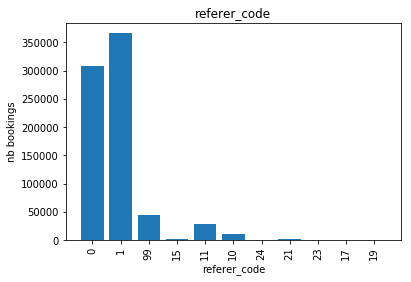

In [42]:
# referer_code
# dict_referer_code, referer_code_list = get_nb_bookings_dict(train_user_df, 'referer_code')
dict_referer_code = read_dict_from_csv('referer_code-nb_bookins.csv')
referer_code_list = list(dict_referer_code.keys())

plot_dict(dict_referer_code, 'referer_code', 'referer_code', 'nb bookings')

#plot_dict(dict_feature_nb_bookings['referer_code'], 'referer_code', 'referer_code', 'nb bookings')

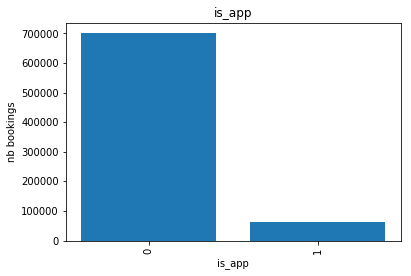

In [43]:
plot_dict(dict_feature_nb_bookings['is_app'], 'is_app', 'is_app', 'nb bookings')

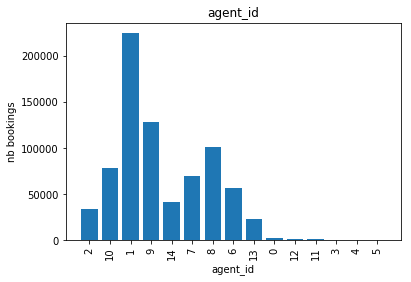

In [44]:
plot_dict(dict_feature_nb_bookings['agent_id'], 'agent_id', 'agent_id', 'nb bookings')

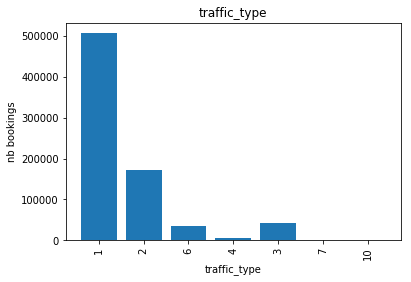

In [45]:
plot_dict(dict_feature_nb_bookings['traffic_type'], 'traffic_type', 'traffic_type', 'nb bookings')

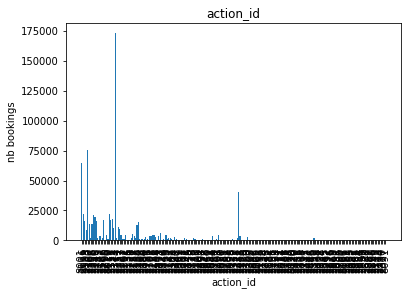

In [46]:
plot_dict(dict_feature_nb_bookings['action_id'], 'action_id', 'action_id', 'nb bookings')

In [ ]:
plot_dict(dict_feature_nb_bookings['reference'], 'reference', 'reference', 'nb bookings')

for key, value in dict_feature_nb_bookings['reference'].items():
    print('{} {}'.format(key, value))

In [ ]:
plot_dict(dict_feature_nb_bookings['step'], 'step', 'step', 'nb bookings')

for key, value in dict_feature_nb_bookings['step'].items():
    print('{} {}'.format(key, value))